In [2]:
import os
import time
import itertools

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from torchvision.transforms import v2
import torch
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# import mediapy as media

%matplotlib inline
%load_ext autoreload
%autoreload 2
from vae_model import *
from ph_dataset import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# torchvision.disable_beta_transforms_warning()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Training helper functions
def make_training_loss_plot(log_dict, figsize=(9,6)):
    """Plot training loss vs step"""
    epoch = log_dict['Epoch'][-1]
    log_df = pd.DataFrame.from_dict(log_dict)
    plt.figure(figsize=figsize)
    sns.lineplot(
        log_df,
        x='Step',
        y='Loss',
        errorbar=None,
    )
    ax = plt.gca()
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    plt.grid(True, which="both", ls="-")
    plt.title(f'Training Loss After {epoch} Epochs')
    plt.show()

def get_device(verbose=False):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    if verbose: print(f"Using device {device}")
    return device

def show_dataset_sample(dataset, nrows=5, ncols=15):
    nsamples = nrows * ncols
    idxs = np.arange(len(dataset))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    
    if len(sample_idxs) < nsamples:
        print('Not enough training data')

    f = plt.figure(figsize=(ncols*1.2, nrows*2))
    f.tight_layout()

    canvas = np.zeros((nrows * 16, ncols * 16))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        ph_data = ph_dataset.get_ph_data(idx)
        ph_img = PulseHeightDataset.inv_log_norm(ph_data['img'])
        canvas[row*16:(row+1)*16, col*16:(col+1)*16] = ph_img

    img_plt = plt.imshow(canvas, cmap='rocket')
    plt.colorbar(img_plt, fraction=0.045)
    plt.title("Pulse Height Dataset Sample")
    plt.show(f)

In [4]:
# Forward method
def vae_forward(
    vae: BetaVAE,
    X: torch.Tensor,
    beta: float,
    sparsity_weight:float,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        X: (N, C, 16, 16) input tensor of Cx16x16 images

    Returns:
        (,) vae loss.
    """
    # Apply positional encoding to input coordinates
    vae.train()
    recon_x, mu, logvar = vae.forward(X)
    return beta_vae_loss_function(recon_x, X, mu, logvar, beta=beta, sparsity_weight=sparsity_weight)

# Sampling method
@torch.inference_mode()
def vae_sample(
    vae: BetaVAE,
    nsamples: int,
    img_cwh: tuple[int, int],
    seed: int,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        nsamples: number of images to create
        img_cwh: image dimensions (W, H)
    Returns:
        (,) 
    """
    vae.eval()
    device = get_device()
    with torch.no_grad():
        torch.manual_seed(seed)
        z = torch.randn(nsamples, vae.latent_dim).to(device)
        return vae.decode(z).cpu()

In [5]:
# VaeWrapper: one level of indirection to make experimentation on the fly easier

class VaeWrapper(nn.Module):
    def __init__(
        self,
        vae: BetaVAE,
        input_img_cwh: tuple[int, int] = (1, 16, 16),
        seed: int = 180,
        beta=1.0,
        sparsity_weight=0.0,
    ):
        super().__init__(),
        self.vae = vae
        self.img_cwh = input_img_cwh
        self.seed = seed
        self.beta = beta
        self.sparsity_weight = sparsity_weight
        
    def forward(self, X: torch.Tensor):
        """
        Args:
            X: (N, C, 16, 16) input tensor of C x 16 x 16 images

        Returns:
            (,) VAE loss.
        """
        self.vae.train()
        assert X[0].shape == torch.Size(self.img_cwh), f"X.shape={X.shape} but img_cwh={self.img_cwh}"
        return vae_forward(self.vae, X, self.beta, self.sparsity_weight)

    @torch.inference_mode()
    def sample(
        self,
        nsamples: int = 16,
    ):
        self.vae.eval()
        return vae_sample(self.vae, nsamples, self.img_cwh, self.seed)

In [6]:
# Define a function to extract latent space representations
def extract_latent_space(vae_model, data_loader, device=get_device()):
    """
    Extract latent space representations from the VAE.
    
    Args:
        vae_model: Trained VAE model.
        data_loader: DataLoader containing images to process.
        device: PyTorch device (e.g., 'cuda' or 'cpu').

    Returns:
        latent_representations: List of latent vectors.
    """
    vae_model.eval()  # Set model to evaluation mode
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            
            # Pass images through encoder
            mu, logvar = vae_model.encode(images)
            z = vae_model.reparameterize(mu, logvar)  # Get latent vector
            
            latent_representations.append(z.cpu().numpy())
    
    # Combine all latent vectors and labels
    latent_representations = np.concatenate(latent_representations, axis=0)
    return latent_representations

# Dimensionality reduction and clustering
def perform_clustering(latent_vectors, method='tsne', n_components=3, n_clusters=9):
    """
    Reduce the dimensionality of latent space and perform clustering.
    
    Args:
        latent_vectors: Array of latent vectors (N x D).
        method: Dimensionality reduction method ('pca' or 'tsne').
        n_components: Number of dimensions to reduce to (default 3).
    
    Returns:
        reduced_data: Latent vectors reduced to n_components dimensions.
        cluster_labels: Cluster assignments from KMeans.
    """
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=30, random_state=42)
    else:
        raise ValueError("Unsupported method. Use 'pca' or 'tsne'.")
    
    reduced_data = reducer.fit_transform(latent_vectors)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Adjust number of clusters as needed
    cluster_labels = kmeans.fit_predict(reduced_data)
    
    return reduced_data, cluster_labels

# Visualization
def visualize_clusters_2d(reduced_data, cluster_labels, cmap="tab20"):
    """
    Visualize the clusters in 2D.
    
    Args:
        reduced_data: 2D array of reduced latent space vectors.
        cluster_labels: Cluster assignments from KMeans.
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap=cmap, s=5)
    plt.colorbar(scatter, label='Cluster ID')
    plt.title('Latent Space Clustering')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    plt.show()

# 3D Visualization
def visualize_clusters_3d(reduced_data, cluster_labels, cmap="tab20"):
    """
    Visualize the clusters in 3D.
    
    Args:
        reduced_data: 3D array of reduced latent space vectors.
        cluster_labels: Cluster assignments from KMeans.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot for clusters
    scatter = ax.scatter(
        reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2],
        c=cluster_labels, cmap=cmap, s=5, label='Clusters'
    )
    ax.set_title('3D Latent Space Clustering')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    fig.colorbar(scatter, label='Cluster ID')

    
    plt.legend()
    plt.show()

def visualize_clusters_3d_orientations(reduced_data, cluster_labels, cmap="tab20"):
    """
    Visualize the clusters in 3D from multiple orientations.
    
    Args:
        reduced_data: 3D array of reduced latent space vectors.
        cluster_labels: Cluster assignments from KMeans.
    """
    fig = plt.figure(figsize=(18, 6))

    # Define three different viewing angles
    orientations = [(30, 30), (30, 150), (30, 270)]
    titles = ['Angle (30°, 30°)', 'Angle (30°, 150°)', 'Angle (30°, 270°)']

    for i, (elev, azim) in enumerate(orientations):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        
        # Scatter plot for clusters
        scatter = ax.scatter(
            reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2],
            c=cluster_labels, cmap=cmap, s=10
        )
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(titles[i])
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')

    # Add a colorbar to the last plot
    # cbar = fig.colorbar(scatter, ax=fig.get_axes())#, shrink=0.6, aspect=10, pad=0.1)
    plt.tight_layout()
    plt.show()

In [7]:
# Training function for VAE model

def train_vae(
    train_config,
    ph_dataset,
    img_cwh = (1, 16, 16),
    seed = 180,
    verbose=True,
):
    device = get_device()
    ### Create panoseti dataloader
    
    train_loader = torch.utils.data.DataLoader(
        dataset = ph_dataset,
        batch_size = train_config['batch_size'],
        shuffle=False,
    )
    if verbose:
        show_dataset_sample(ph_dataset, nrows=15, ncols=15)
        ph_dataset.reset_ph_generator()
    
    ### Model training config
    in_channels = img_cwh[0]
    model = VaeWrapper(
        vae = train_config['model'](
            in_channels,
            hidden_dim = train_config['hidden_dim'],
            latent_dim = train_config['latent_dim'],
        ),
        input_img_cwh = img_cwh,
        seed = seed,
        beta = train_config['beta'],
        sparsity_weight = train_config['sparsity_weight'],
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'], weight_decay=train_config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=train_config['gamma'])

    ### Train Model
    log_dict = {
        'Step': [],
        'Loss': [],
        'Epoch': []
    }
    os.makedirs('vae_model_checkpoints', exist_ok=True)
    
    step = 0
    for epoch in range(1, train_config['num_epochs'] + 1):
        torch.manual_seed(seed + epoch)
        
        for x in tqdm(train_loader, unit="batch"):
            step += 1
            model.train()
            x = x.to(device)

            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()
    
            if step % 5 == 0: 
                log_dict['Epoch'].append(epoch)
                log_dict['Step'].append(step)
                log_dict['Loss'].append(np.abs(loss.item()))
        
        # Update learning rate
        scheduler.step()

        
        # Make figures for this Epoch
        print(f'Epoch {epoch}\n')
        
        if (epoch - 1) % 5 == 0:
            print('current lr = ', scheduler.get_lr())
            make_training_loss_plot(log_dict)
            plot_sample(model, nrows=15, ncols=15)

            latent_vectors = extract_latent_space(model.vae, train_loader)
            reduced_data, cluster_labels = perform_clustering(latent_vectors, method='tsne', n_clusters=train_config['n_clusters'])
            visualize_clusters_3d_orientations(reduced_data, cluster_labels)
            # make_training_loss_plot()
        if (epoch - 1) % 20 == 0:
            # make_training_loss_plot(log_dict)
            torch.save(model, f"vae_model_checkpoints/vae2_nepoch={epoch}_ldim={train_config['latent_dim']}")

    log_df = pd.DataFrame.from_dict(log_dict)
    make_training_loss_plot(log_dict)
    plot_sample(model)
    return model, log_df

In [11]:
def plot_sample(model: VaeWrapper, nrows=5, ncols=15, size=16):
    nsamples = nrows * ncols
    sampled_images = model.sample(nsamples = nsamples)
    assert len(sampled_images) == nrows * ncols
    # Sample from the VAE model
    imgs = np.zeros((nrows * size, ncols * size))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        log_norm_ph_img = sampled_images[i, 0, ...].reshape(size, size).numpy()
        ph_img =  PulseHeightDataset.inv_log_norm(log_norm_ph_img)
        imgs[row*size:(row+1)*size, col*size:(col+1)*size] = ph_img
    # Plot image samples
    f = plt.figure(figsize=(ncols*1.2, nrows*2))
    f.tight_layout()
    img_plt = plt.imshow(imgs, cmap='rocket')
    plt.title("VAE-Generated Pulse Height Images")
    plt.colorbar(img_plt, fraction=0.045)
    plt.show()

In [12]:
# ph_dataset_config = {
#     "data_dir": './test_data',
#     "run_dir": 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd',
#     "module_ids": 'all',
# }

ph_dataset_config = {
    "data_dir": './test_data',
    "run_dir": 'obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd',
    "module_ids": 'all',
}

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float),
])

ph_dataset = PulseHeightDataset(ph_dataset_config, transform=transform, log_level=logging.ERROR)

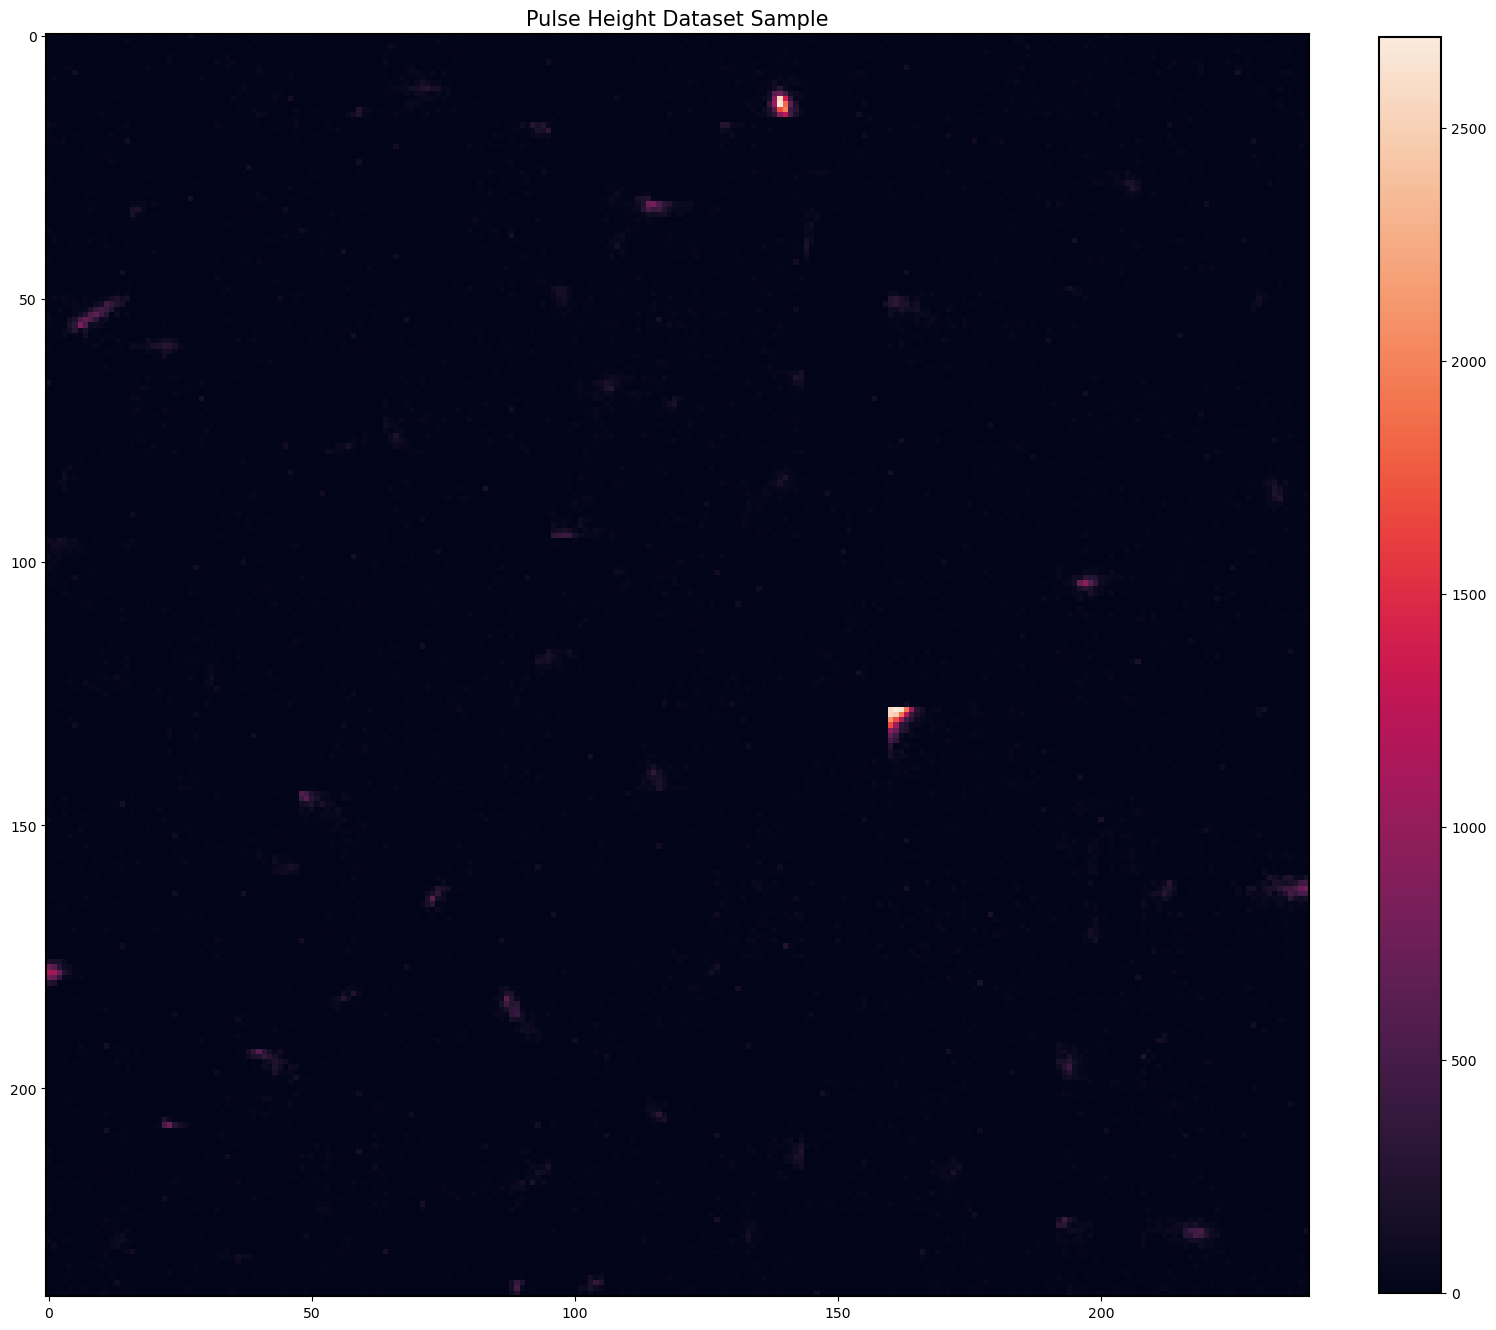

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 45.79batch/s]


Epoch 1

current lr =  [0.0001]


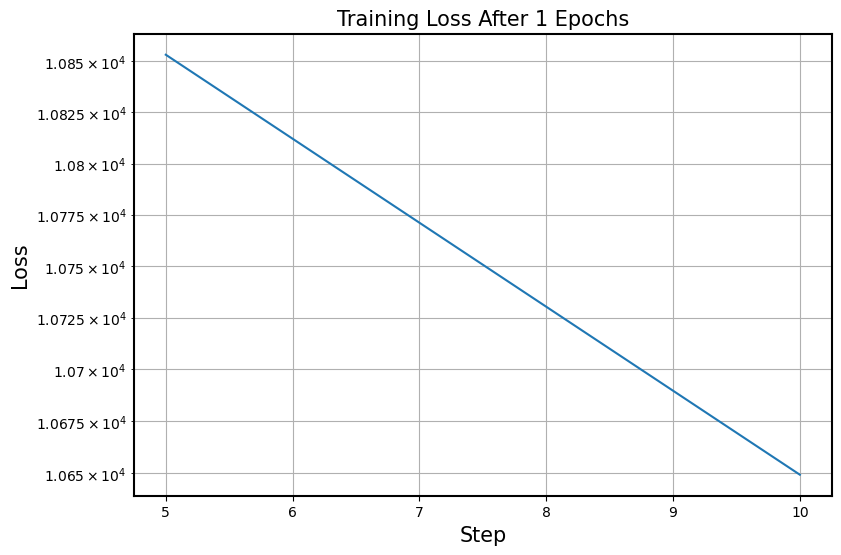

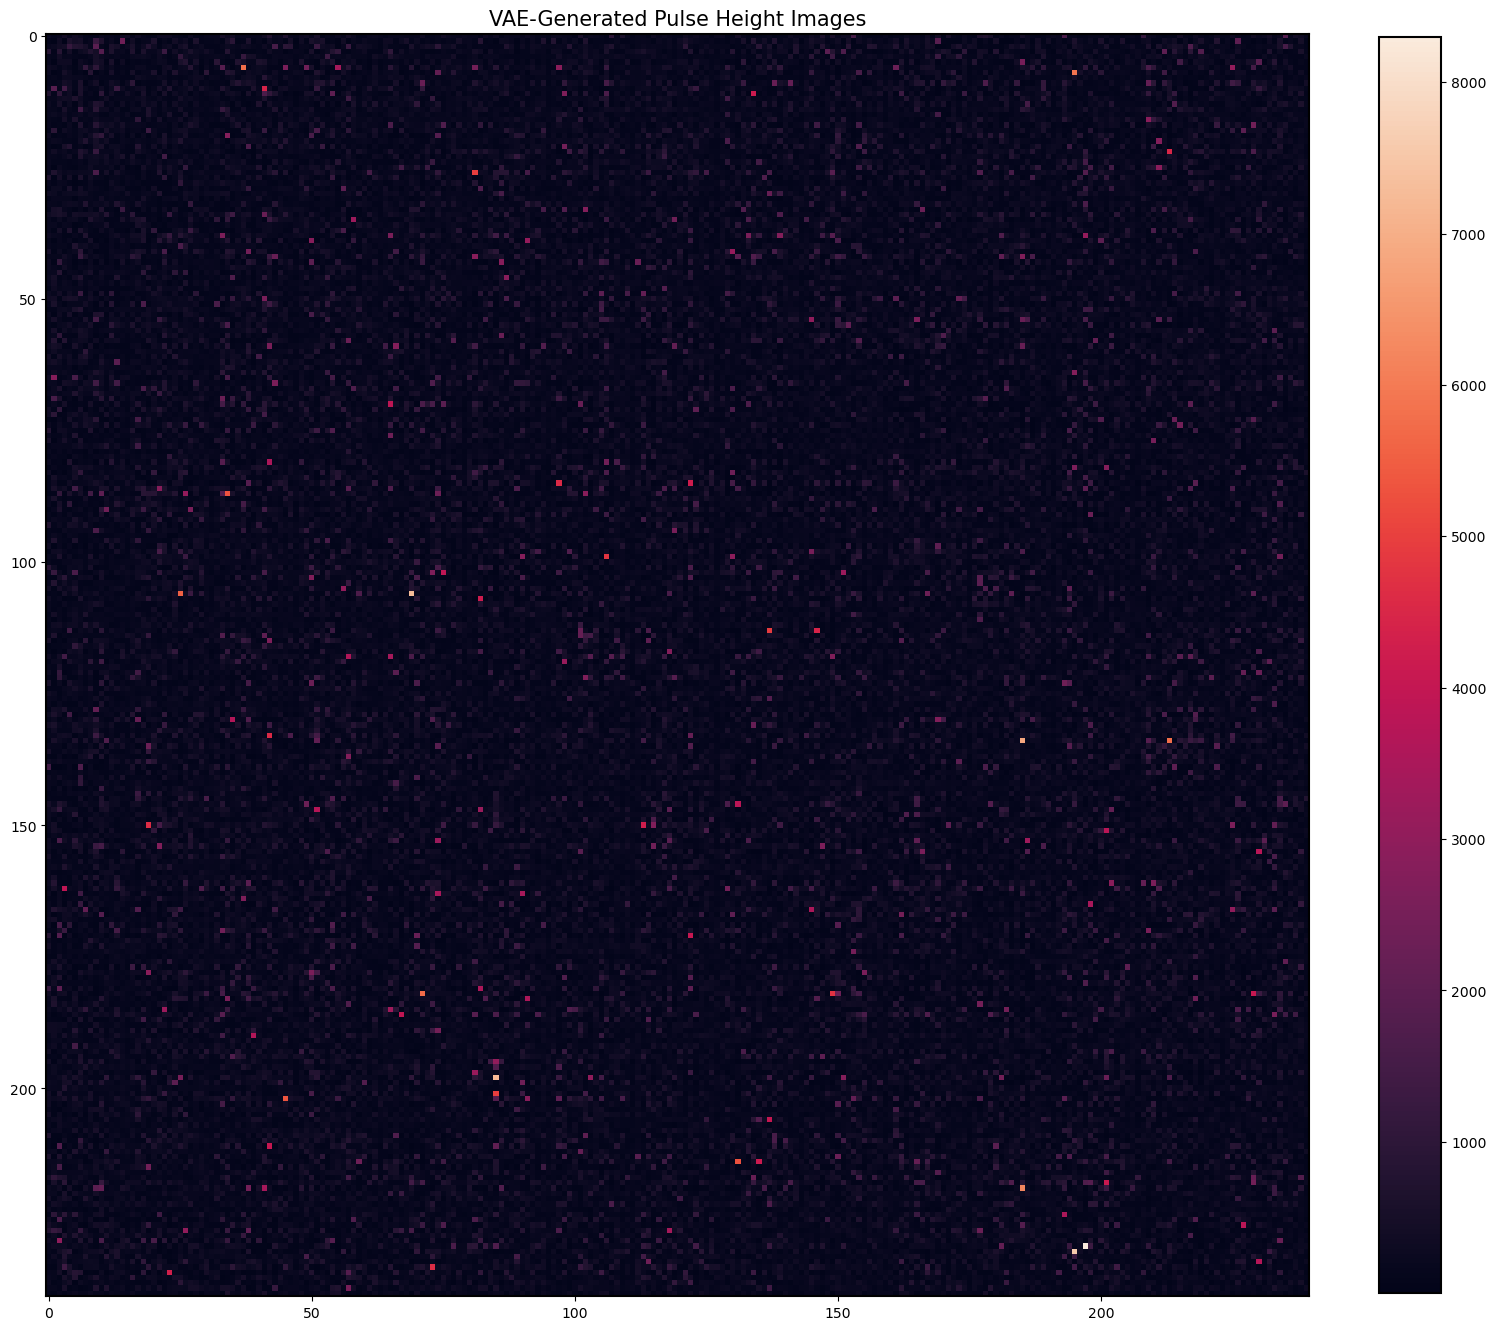

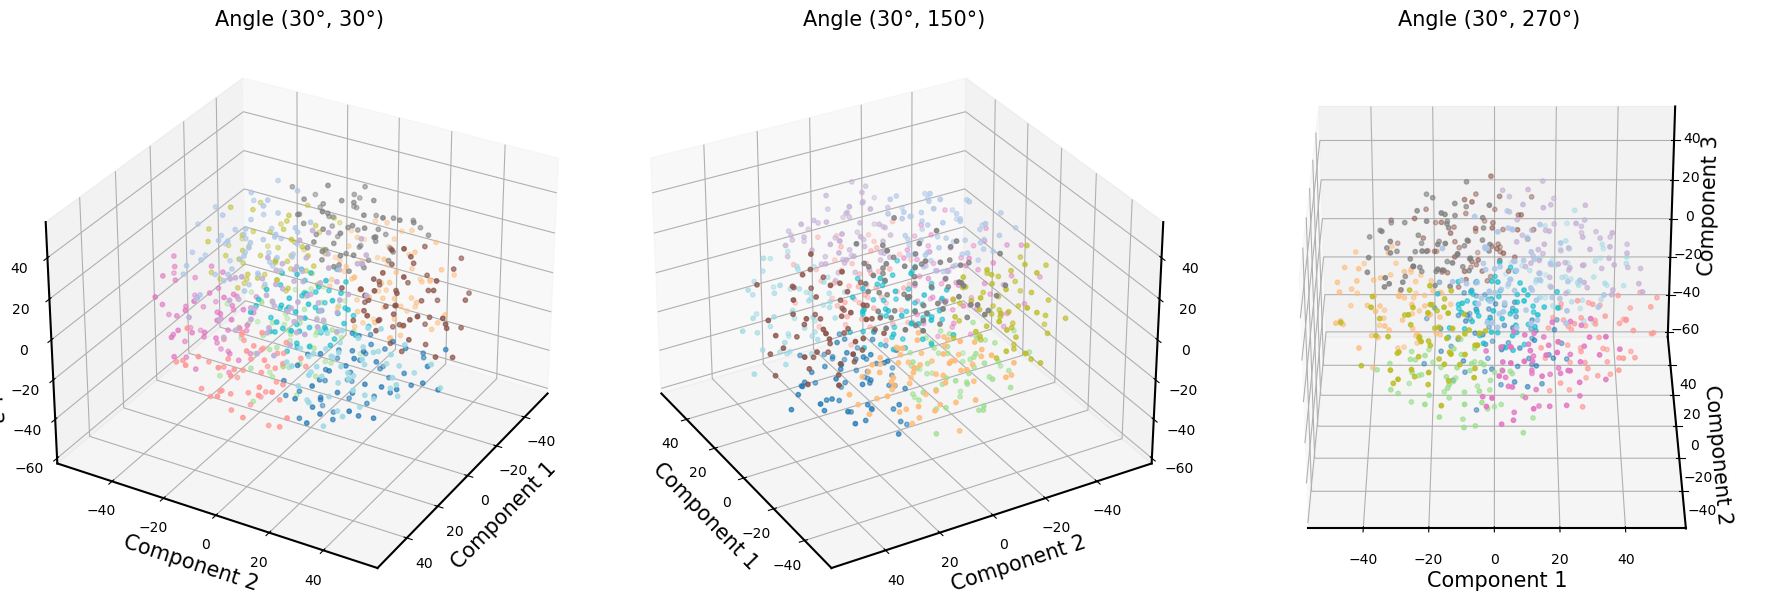

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.77batch/s]


Epoch 2



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 49.02batch/s]


Epoch 3



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 49.15batch/s]


Epoch 4



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 53.62batch/s]


Epoch 5



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 52.66batch/s]


Epoch 6

current lr =  [0.0001]


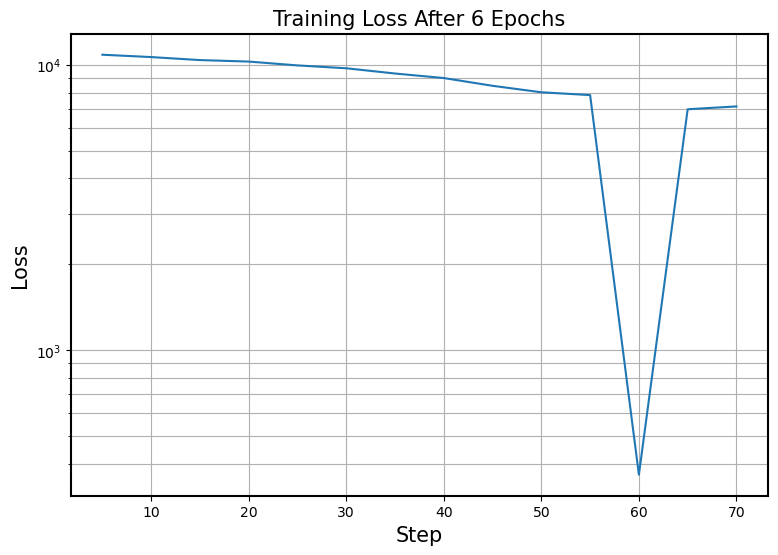

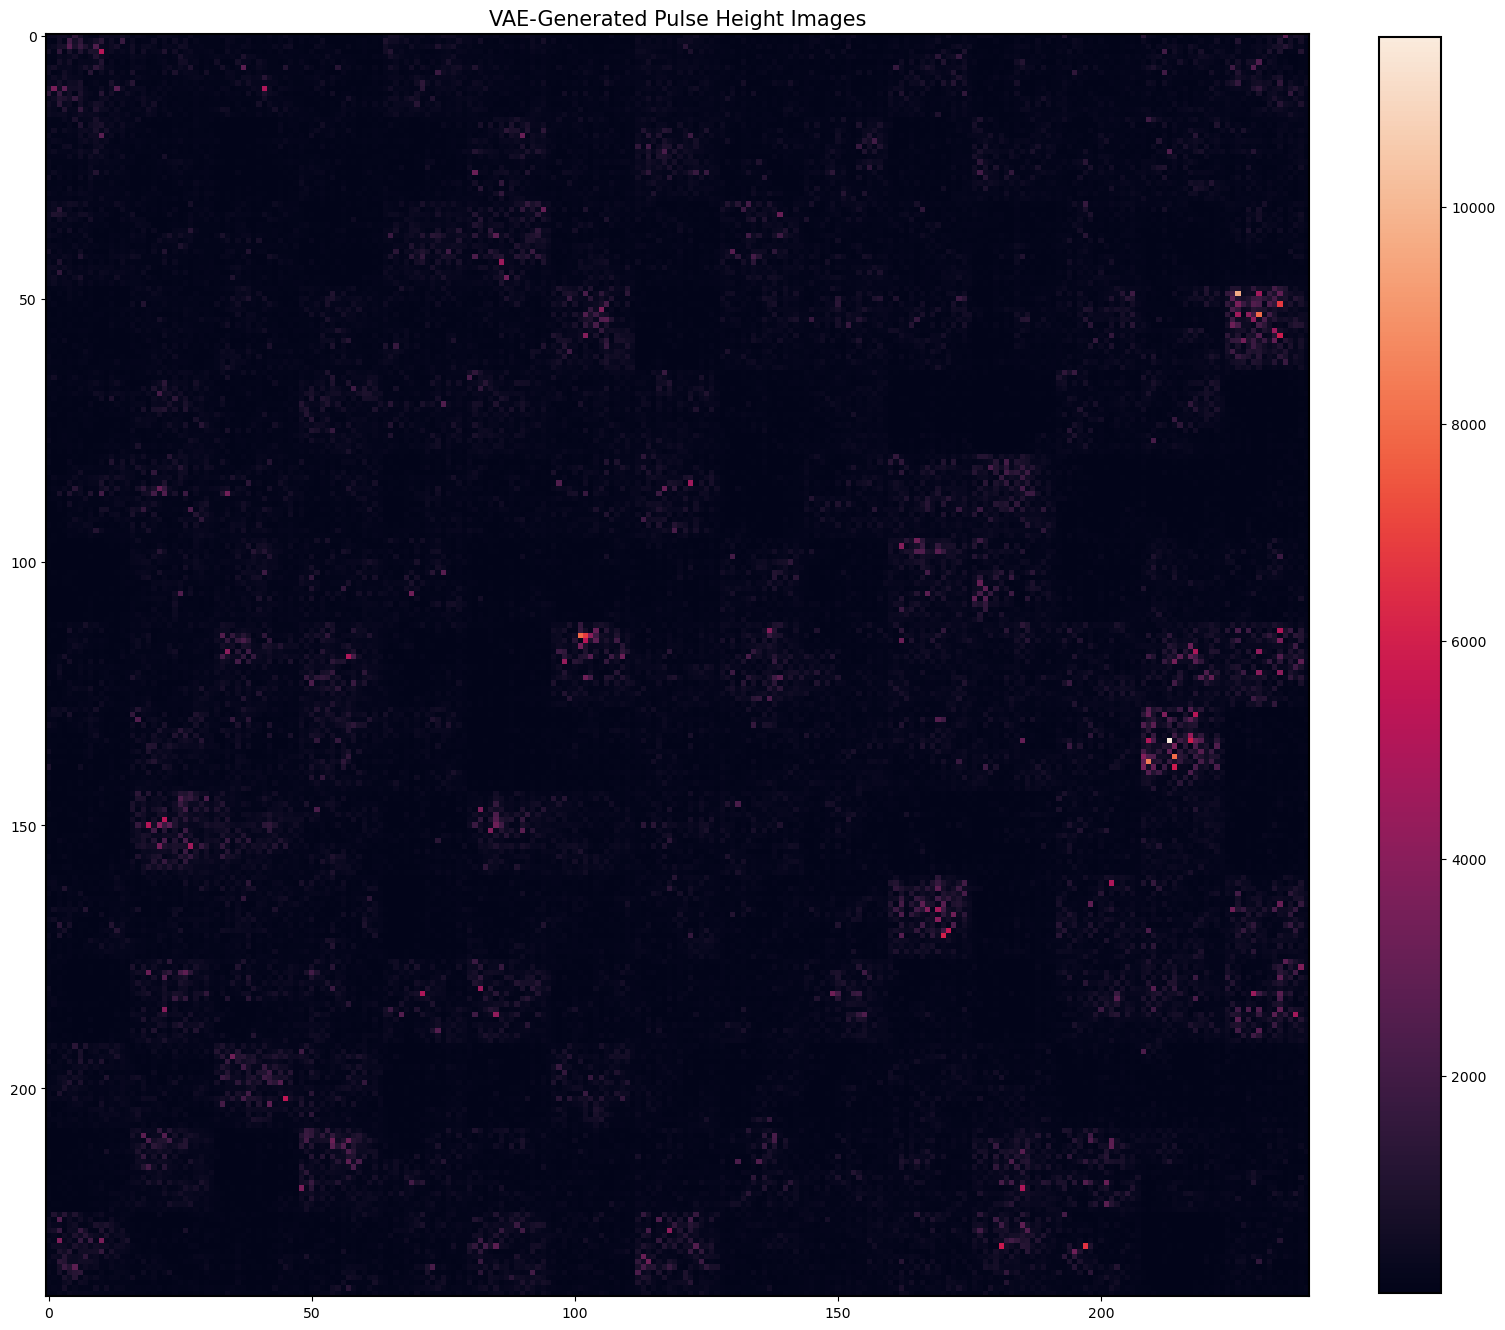

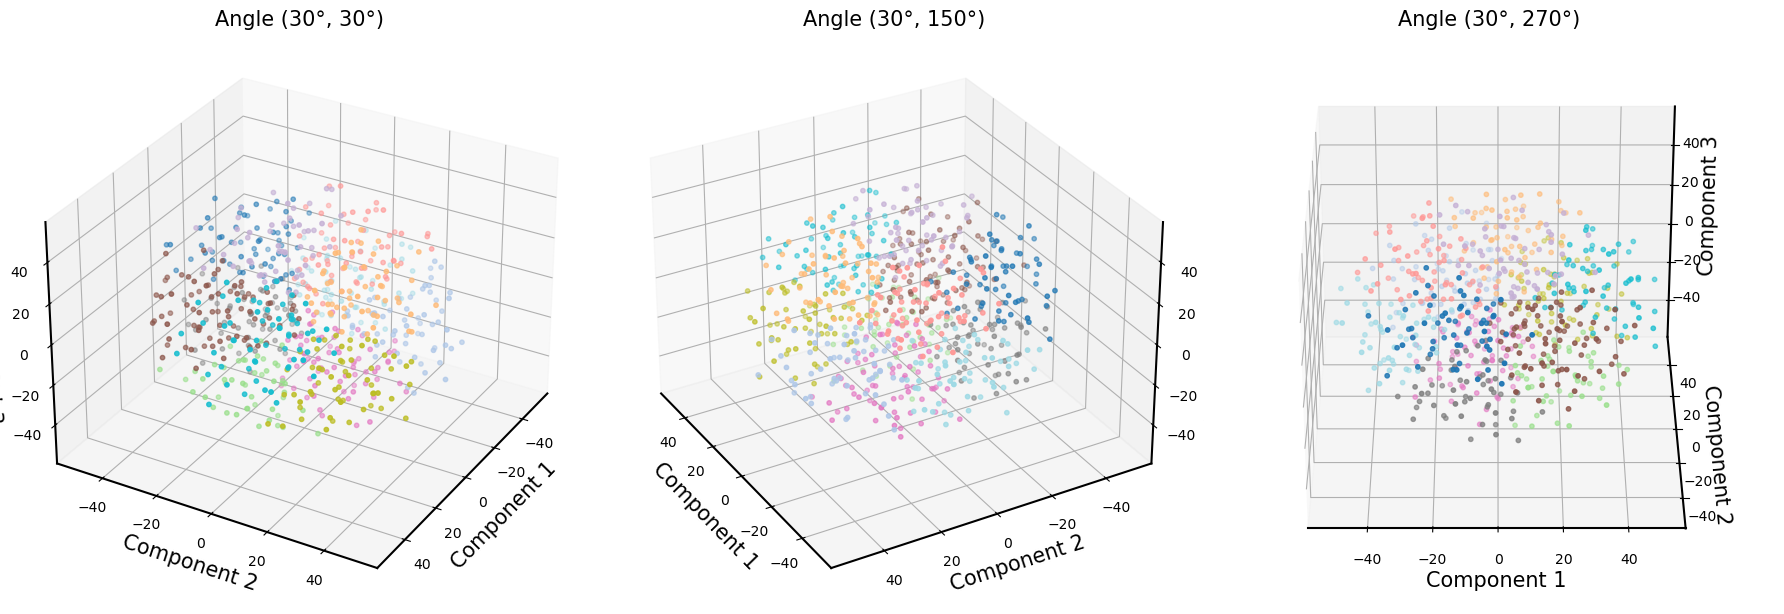

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 51.03batch/s]


Epoch 7



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.85batch/s]


Epoch 8



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.01batch/s]


Epoch 9



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 51.91batch/s]


Epoch 10



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 52.19batch/s]


Epoch 11

current lr =  [0.0001]


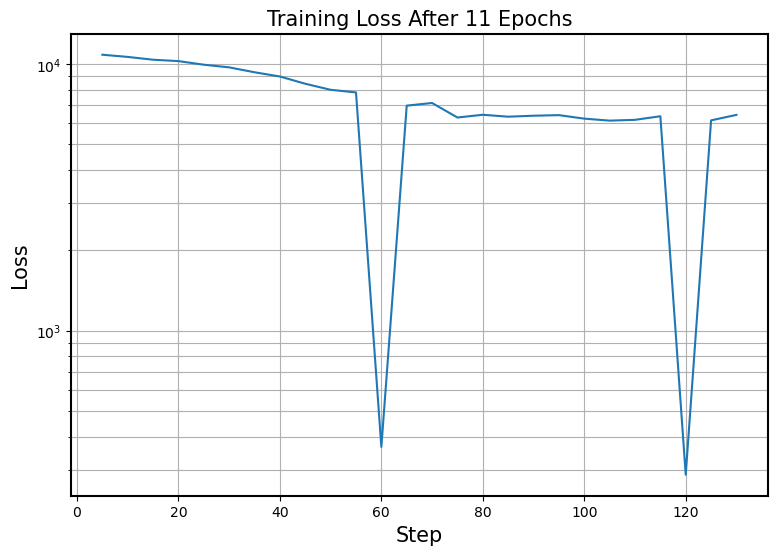

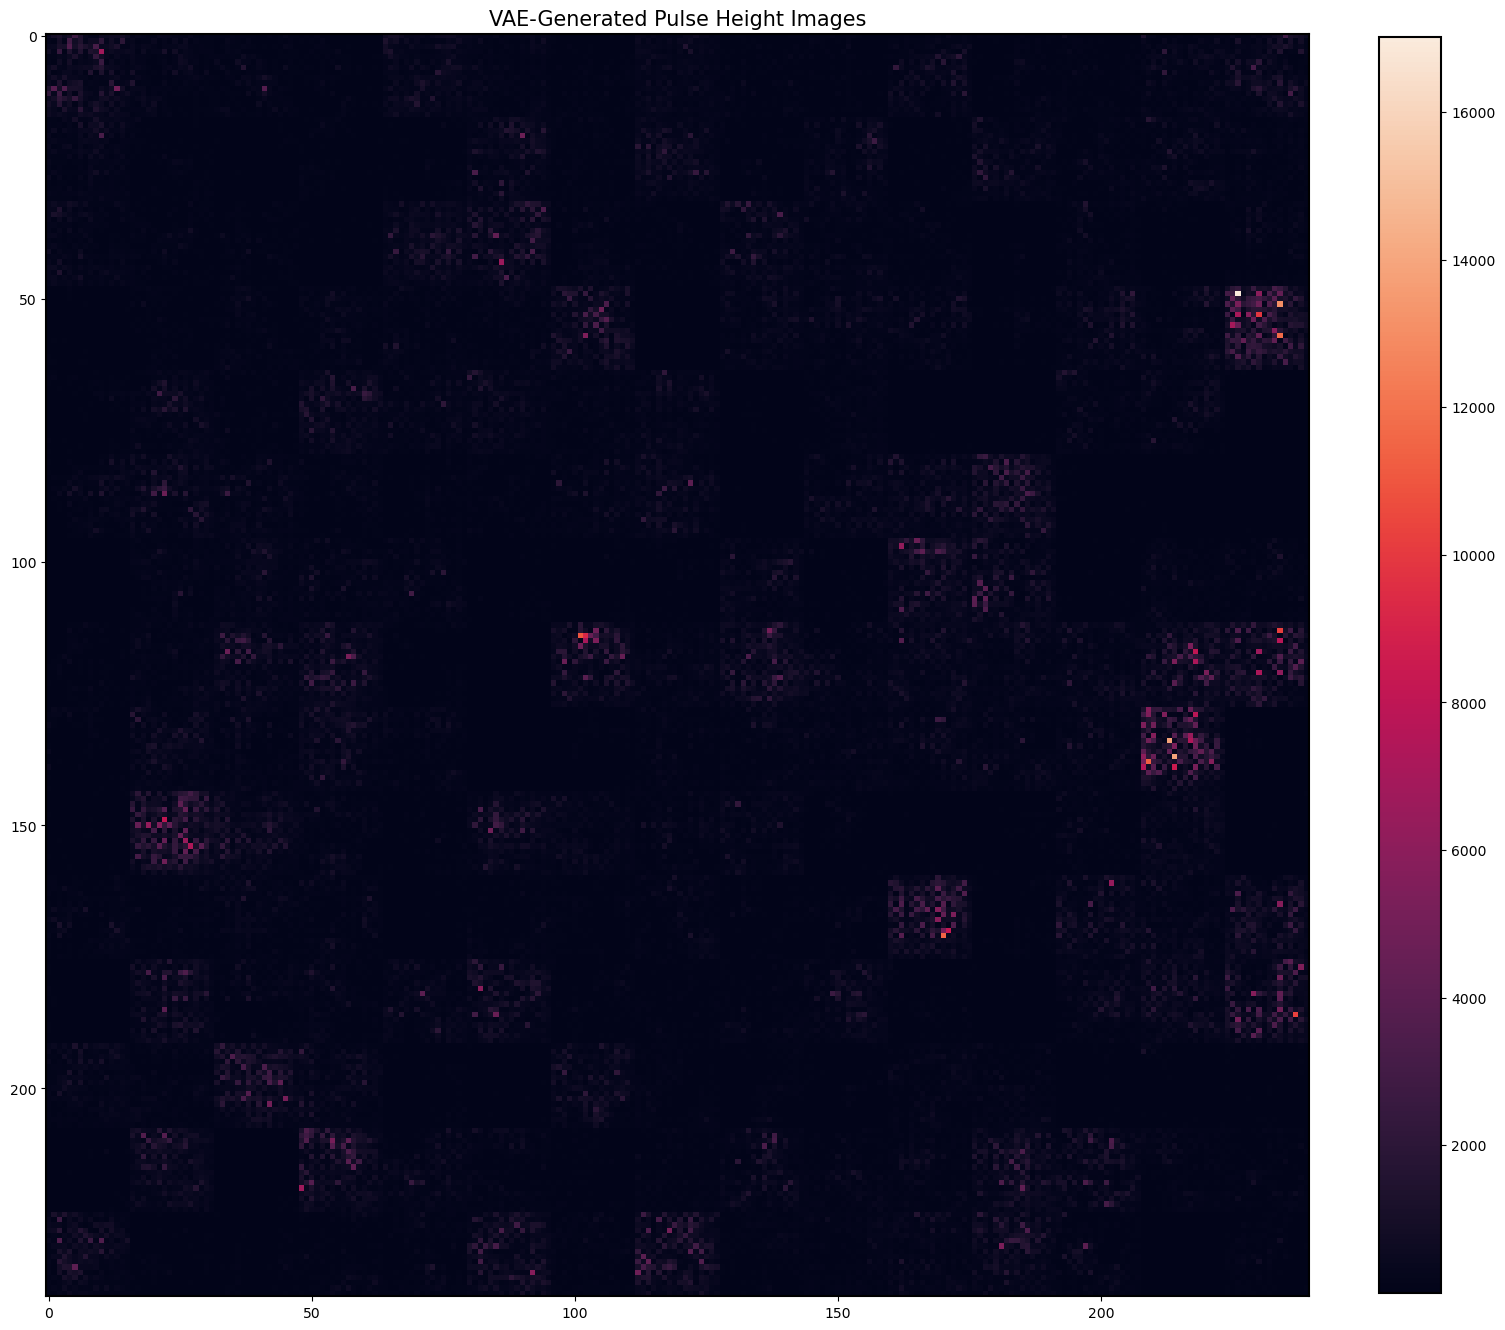

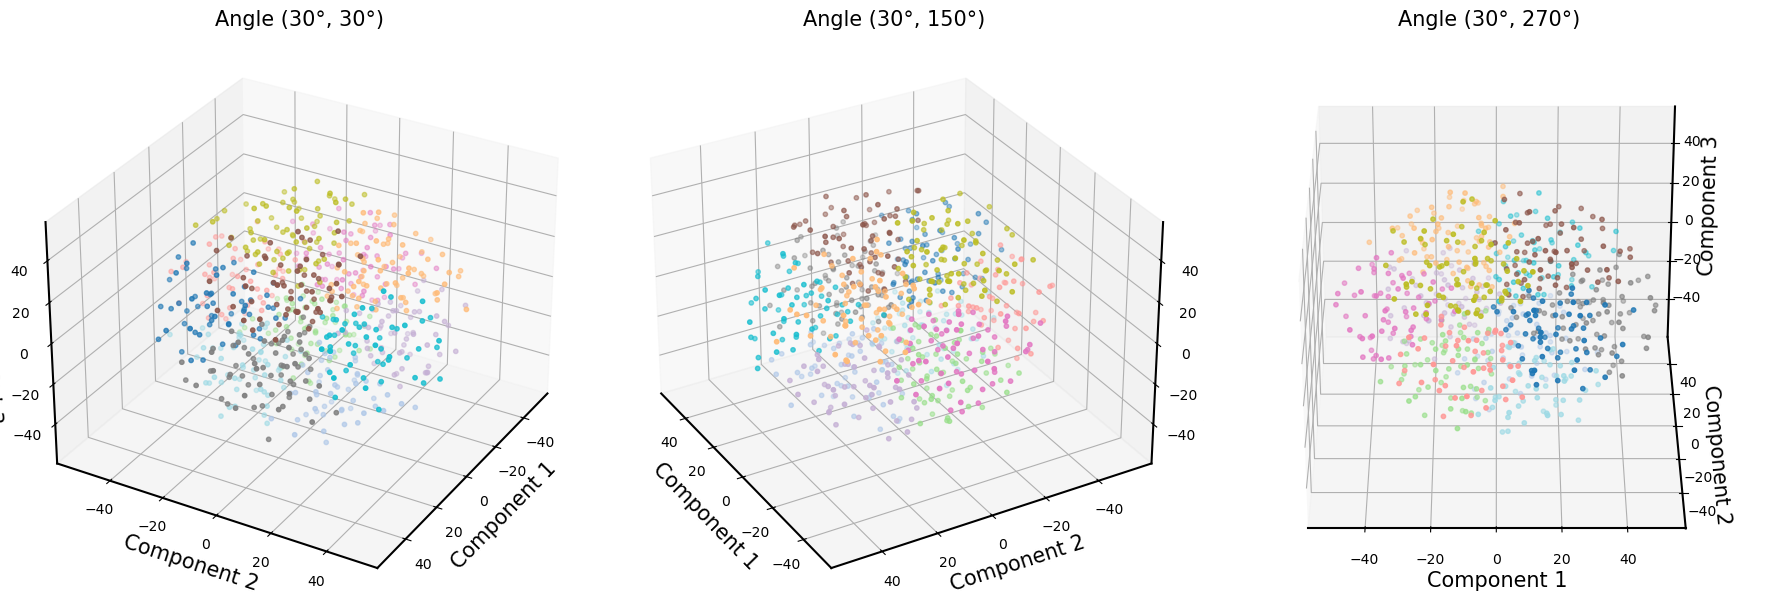

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 52.29batch/s]


Epoch 12



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 37.87batch/s]


Epoch 13



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.88batch/s]


Epoch 14



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 53.79batch/s]


Epoch 15



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.13batch/s]


Epoch 16

current lr =  [0.0001]


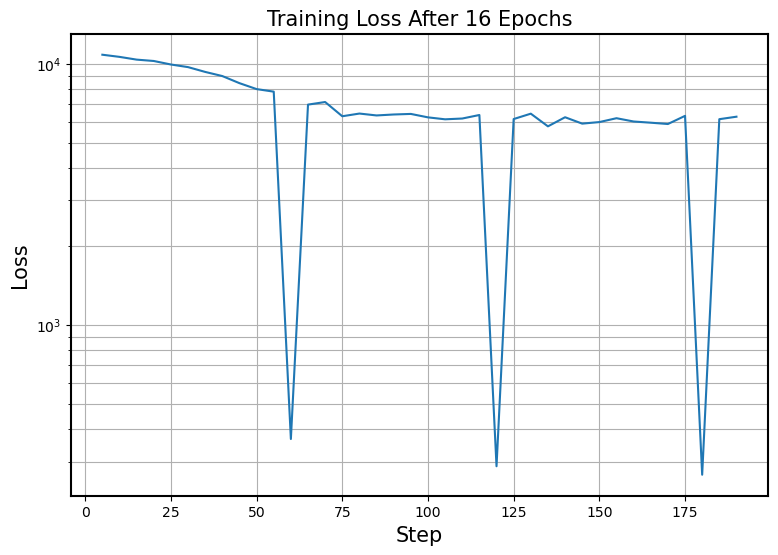

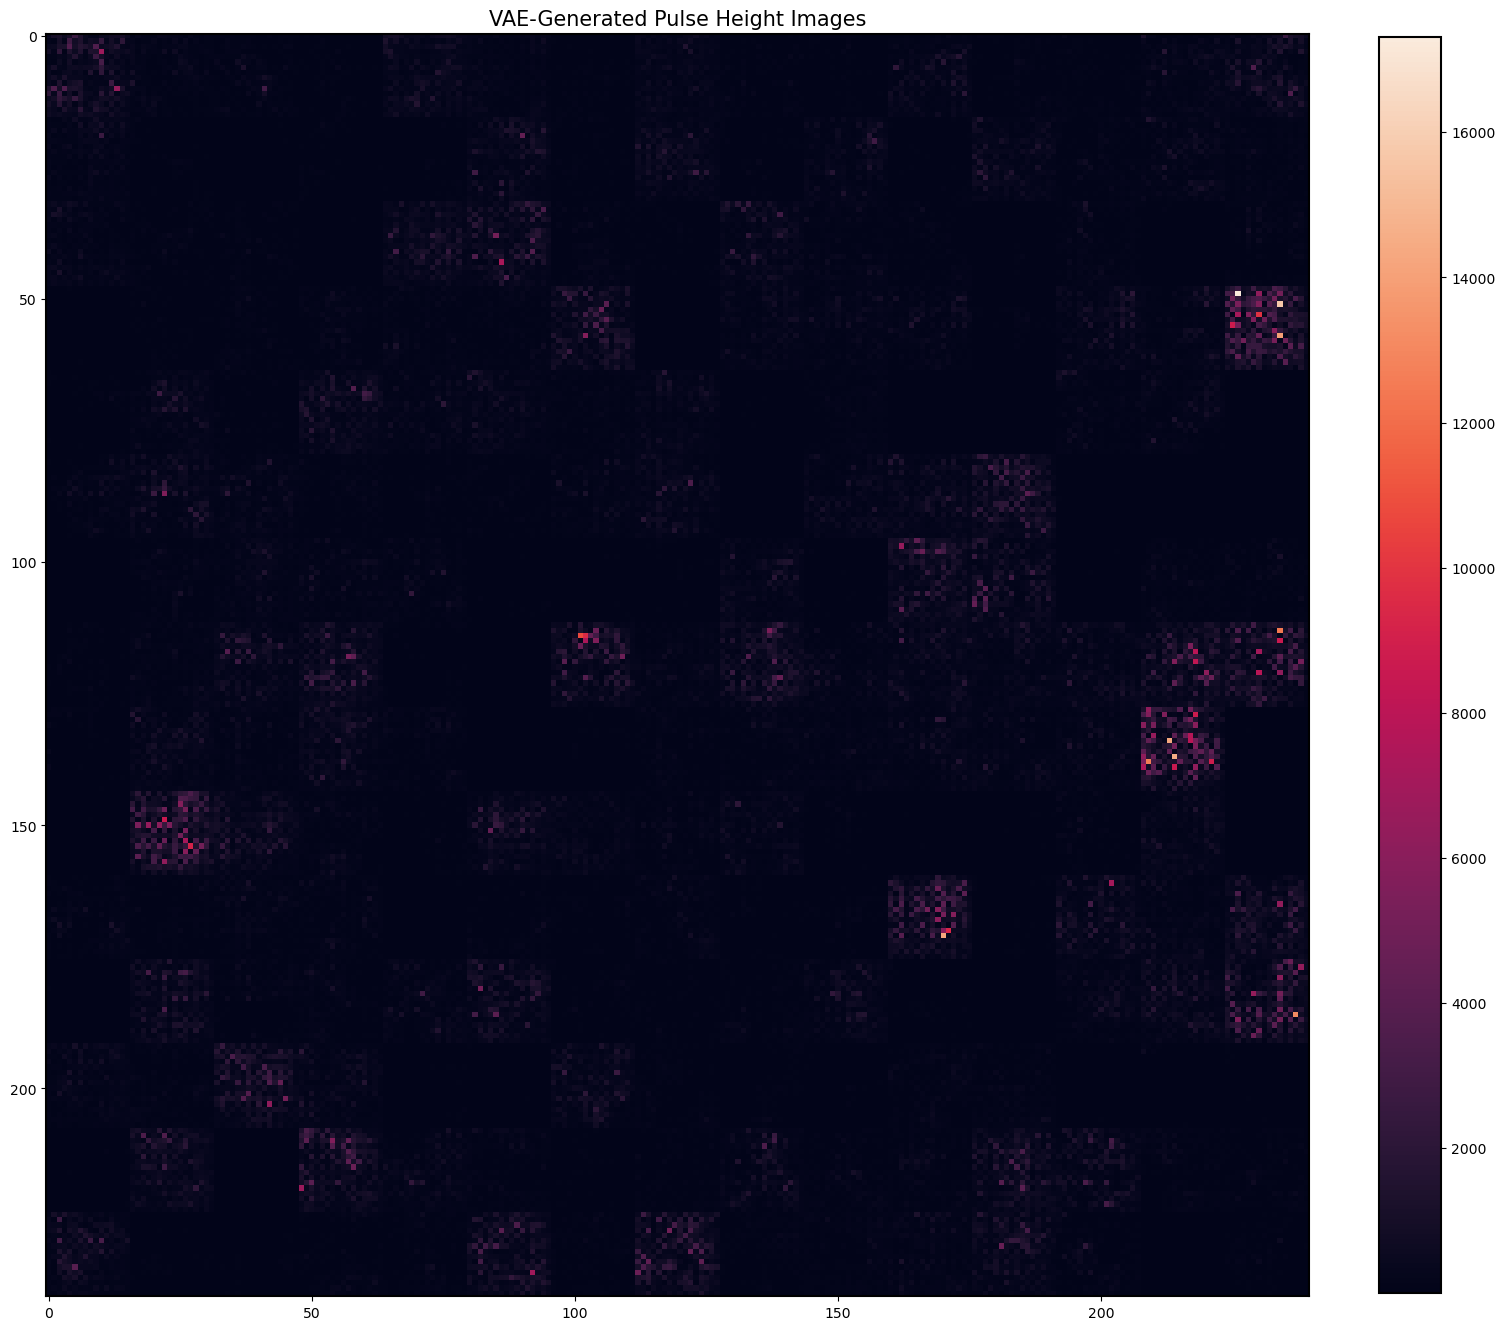

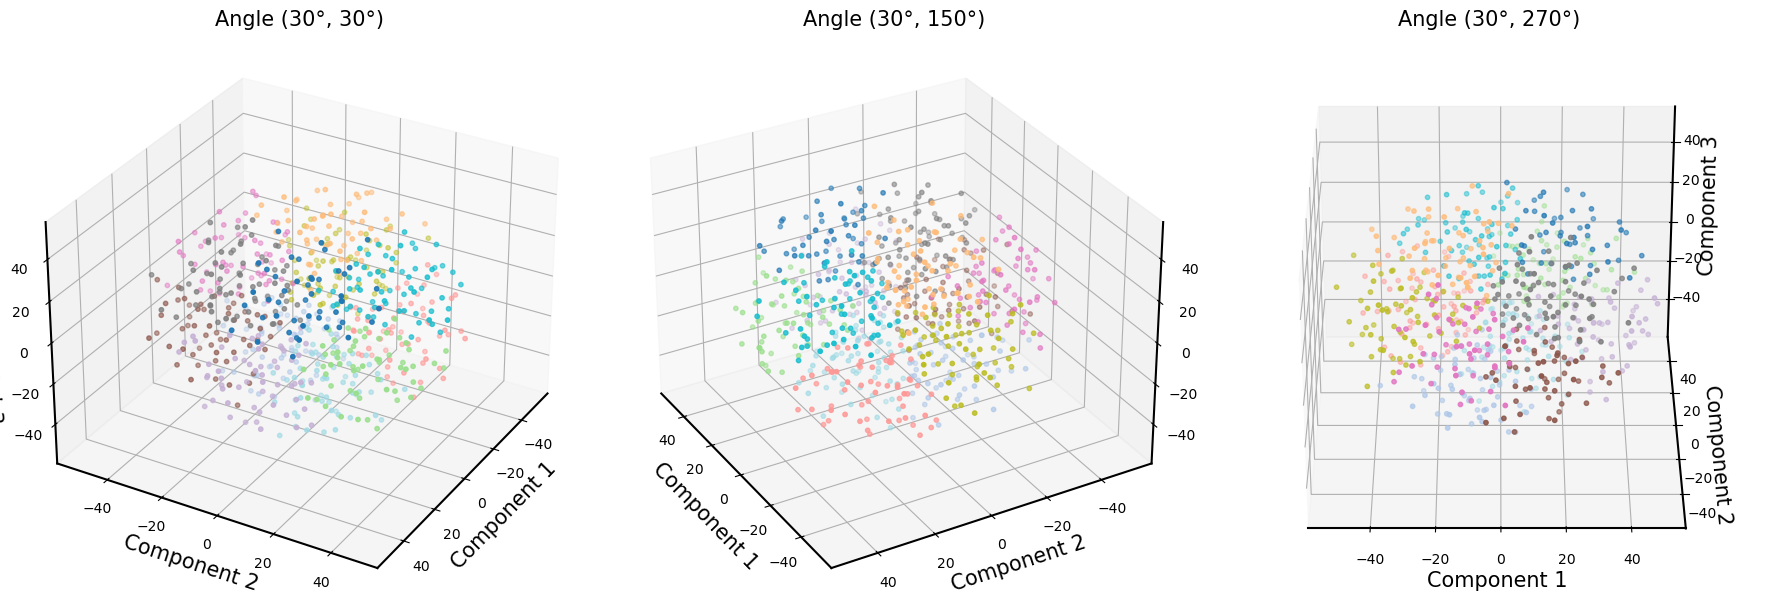

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 33.57batch/s]


Epoch 17



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 48.33batch/s]


Epoch 18



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 49.91batch/s]


Epoch 19



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.70batch/s]


Epoch 20



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 51.50batch/s]


Epoch 21

current lr =  [0.0001]


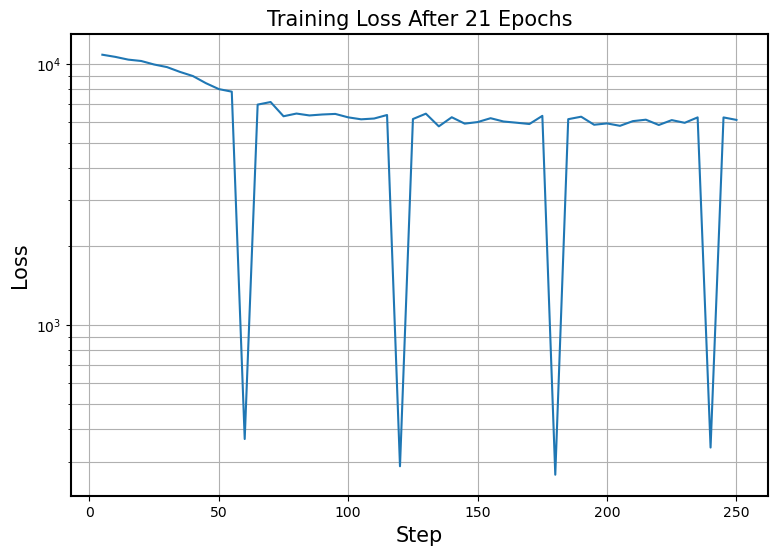

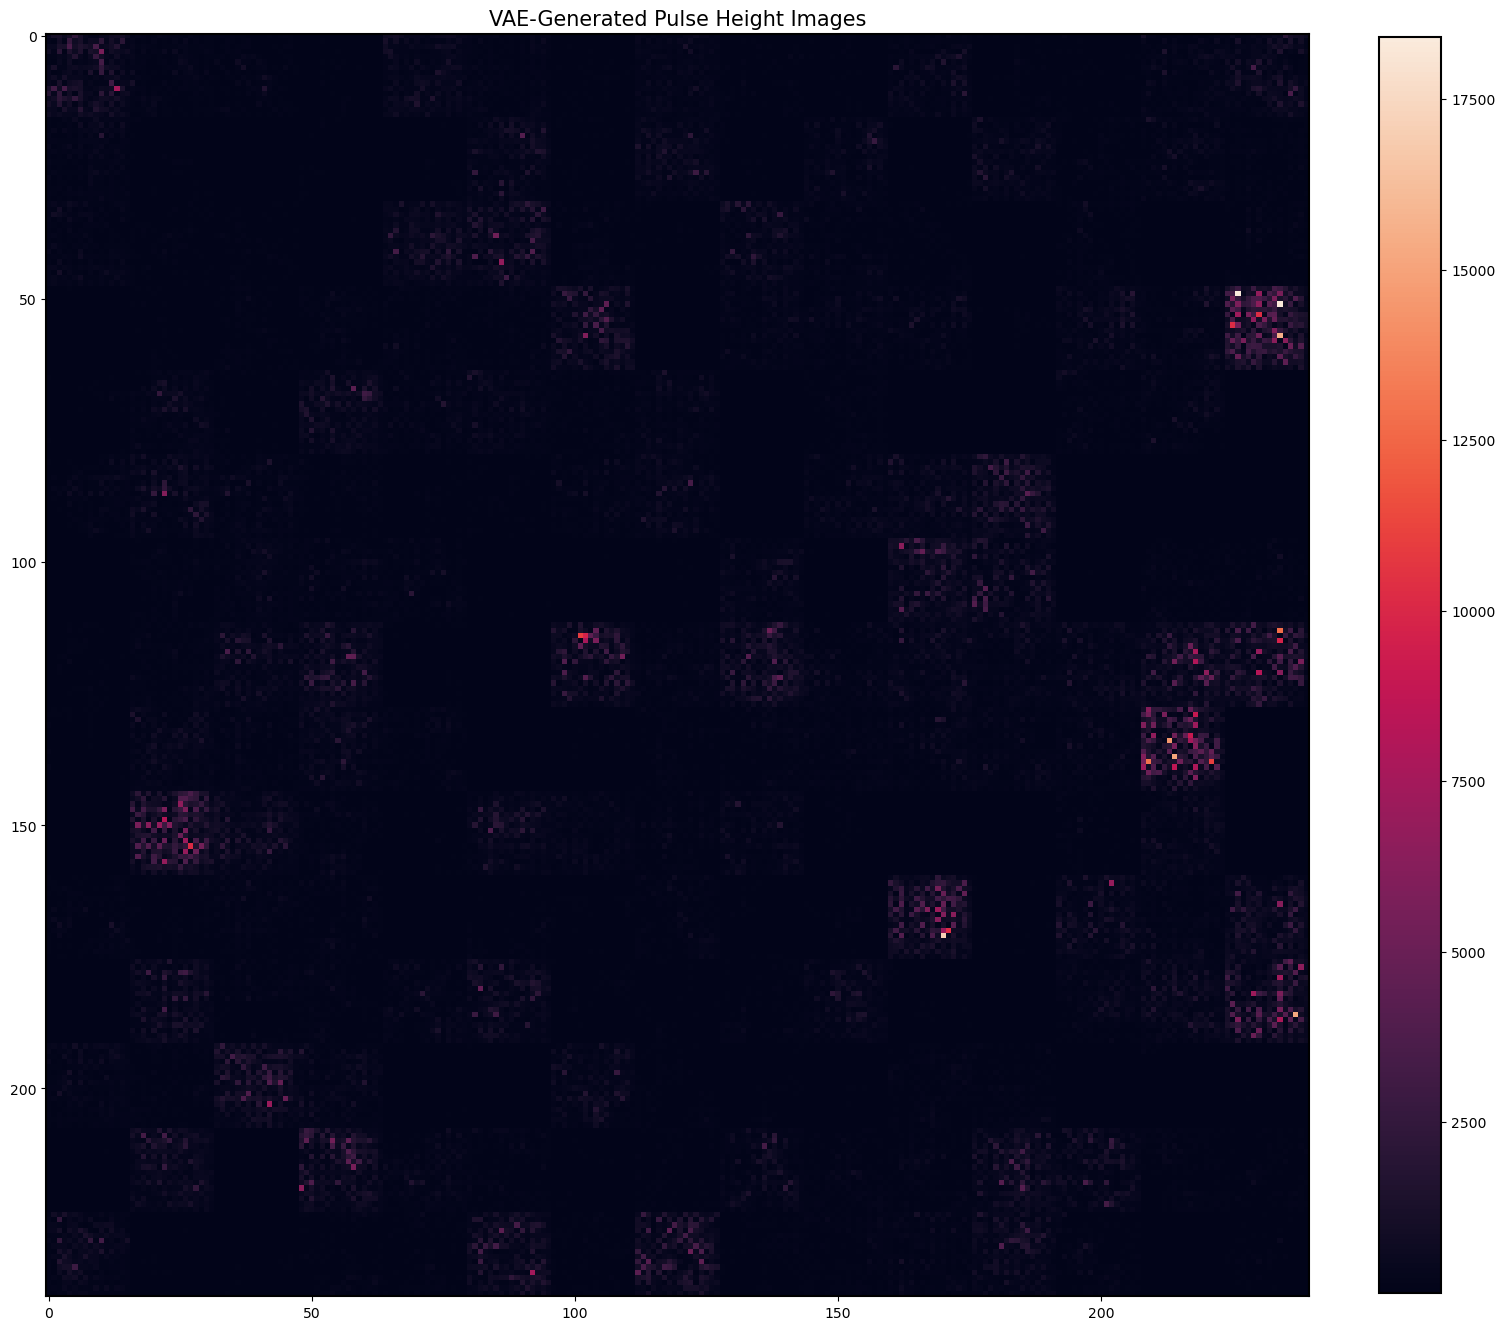

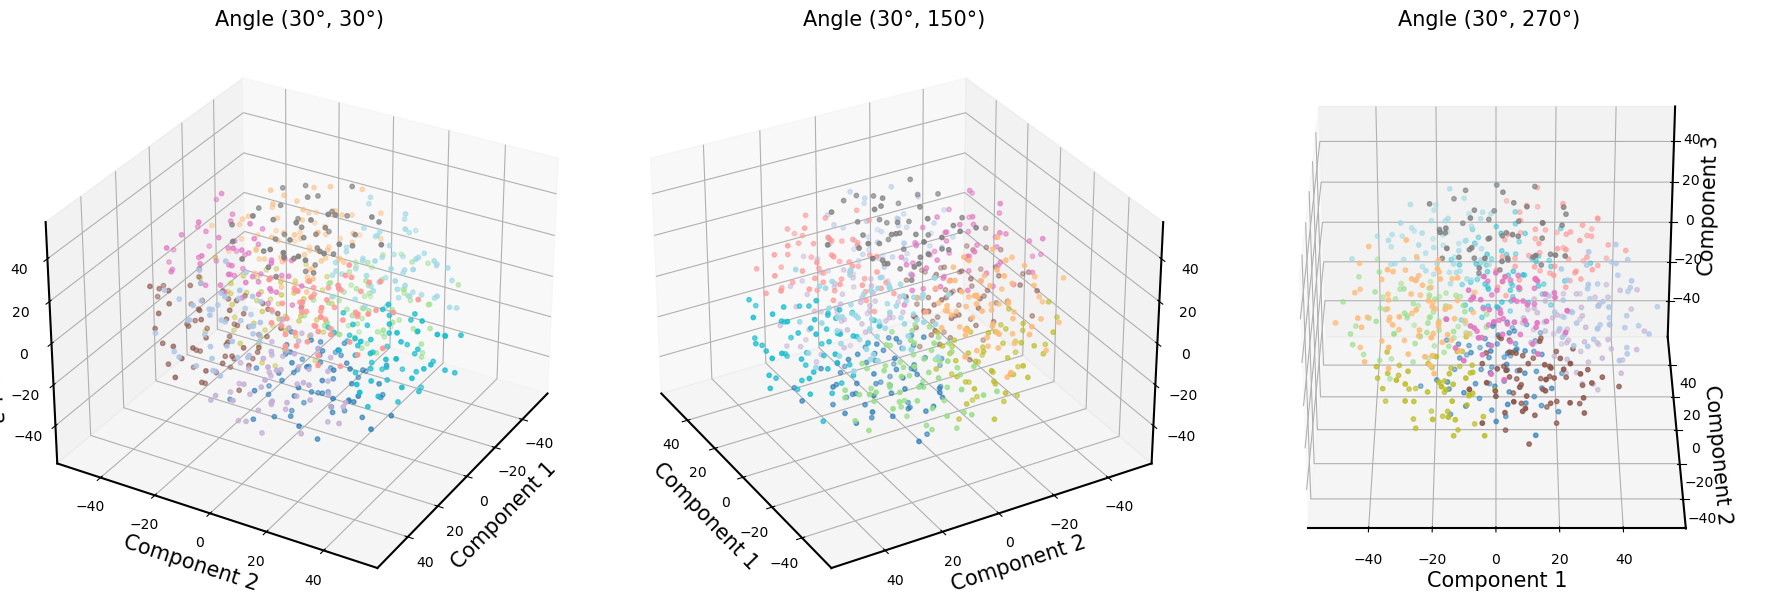

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 33.54batch/s]


Epoch 22



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 51.74batch/s]


Epoch 23



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 52.14batch/s]


Epoch 24



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 40.61batch/s]


Epoch 25



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.83batch/s]


Epoch 26

current lr =  [0.0001]


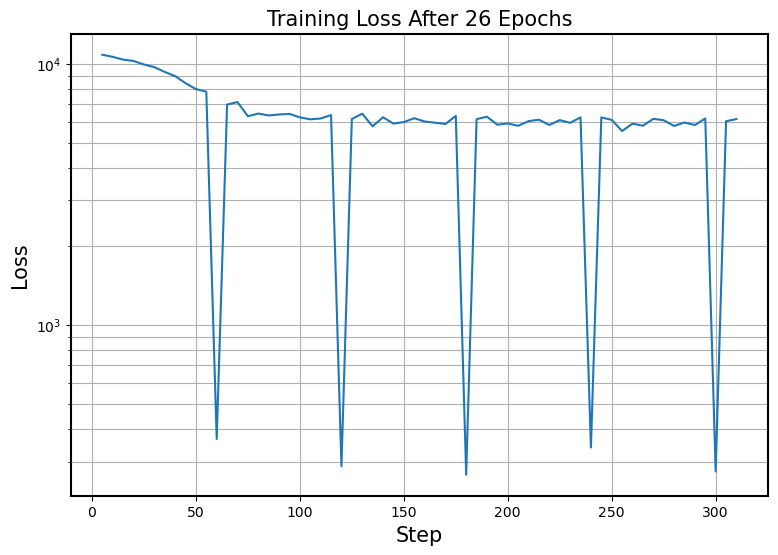

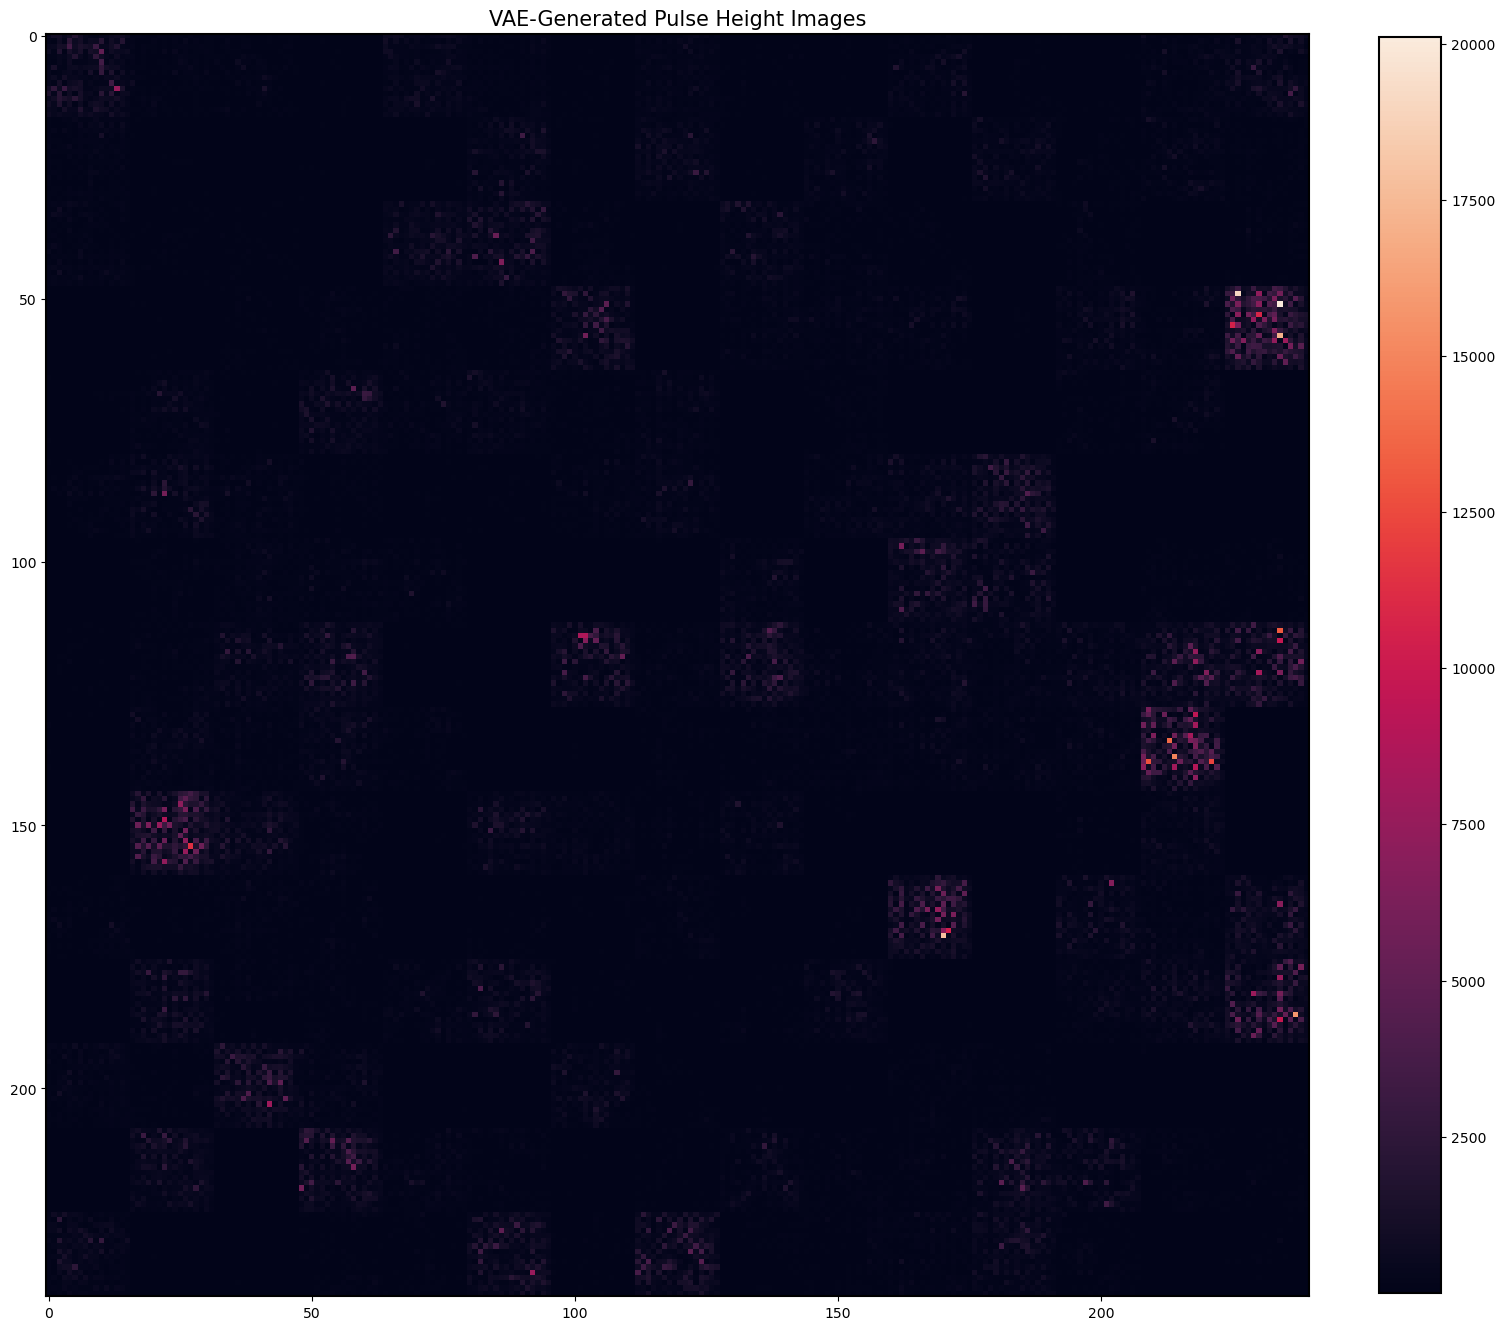

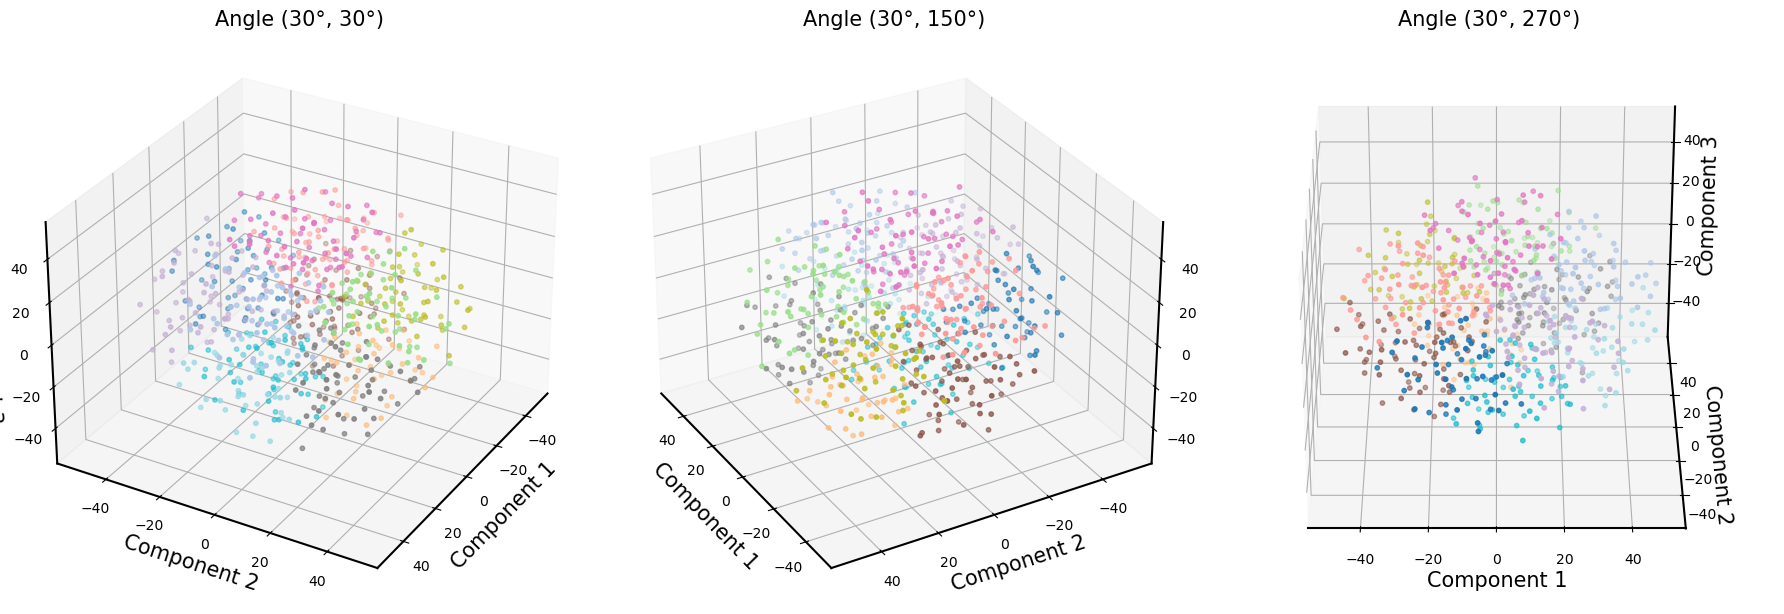

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 41.03batch/s]


Epoch 27



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 51.28batch/s]


Epoch 28



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.01batch/s]


Epoch 29



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 48.27batch/s]


Epoch 30



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 49.04batch/s]


Epoch 31

current lr =  [0.0001]


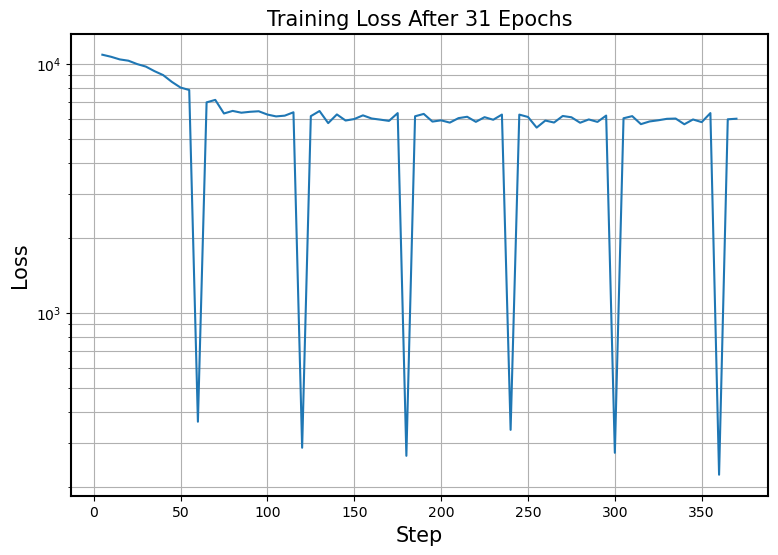

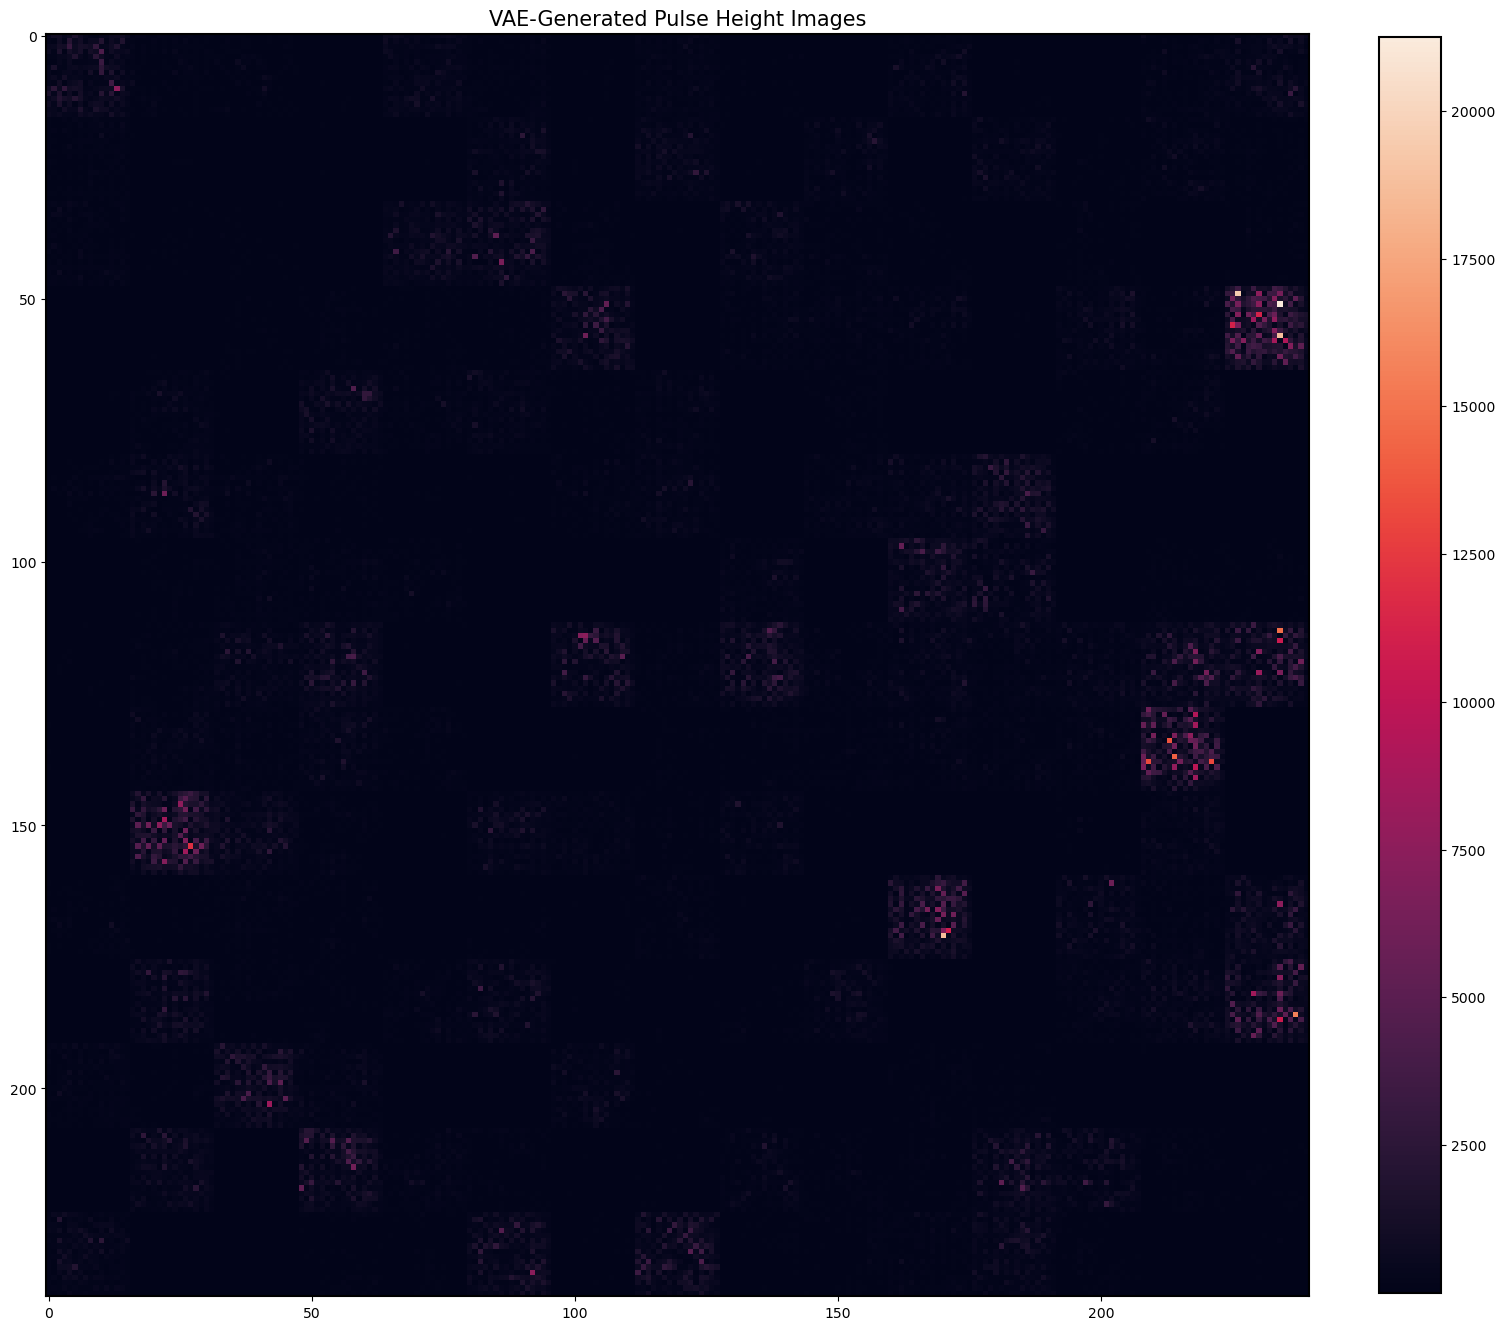

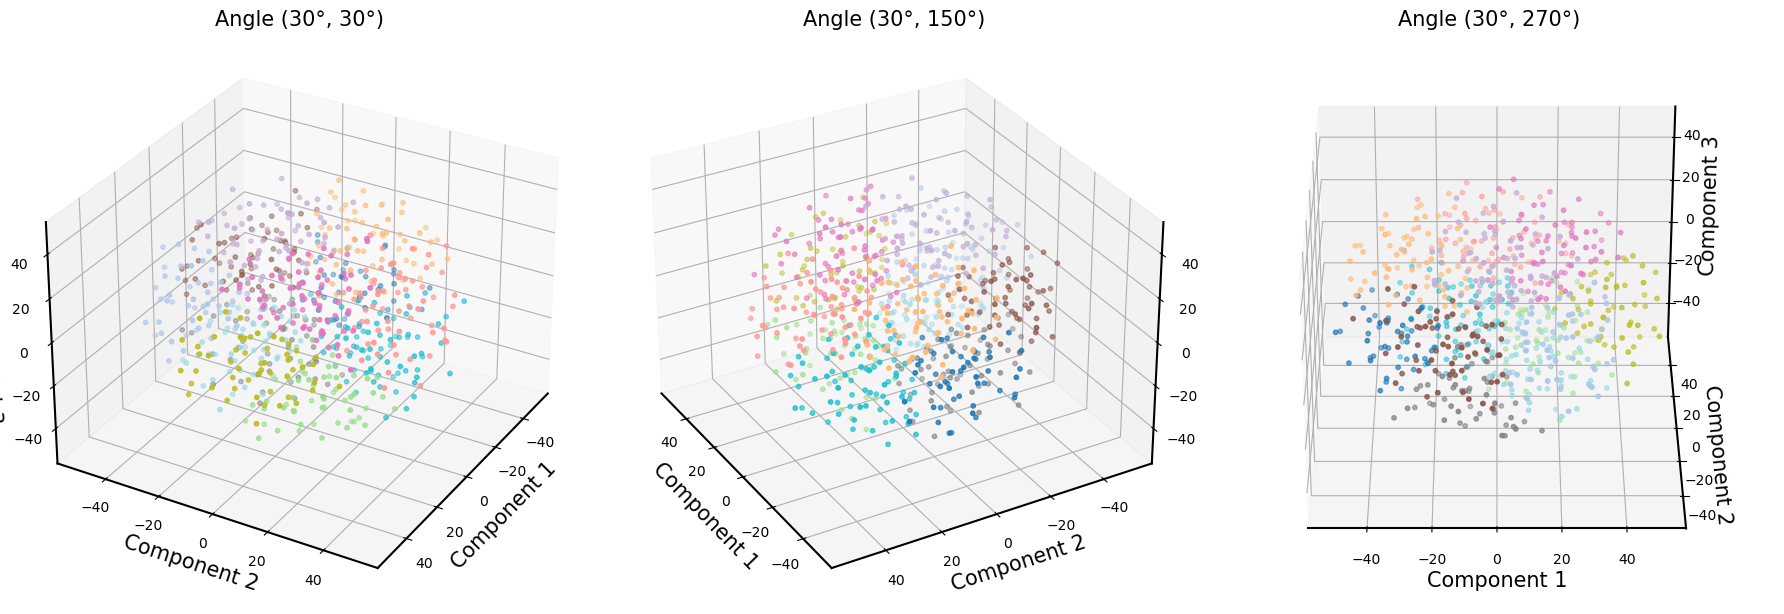

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 47.45batch/s]


Epoch 32



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 49.61batch/s]


Epoch 33



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.39batch/s]


Epoch 34



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 49.40batch/s]


Epoch 35



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 49.30batch/s]


Epoch 36

current lr =  [0.0001]


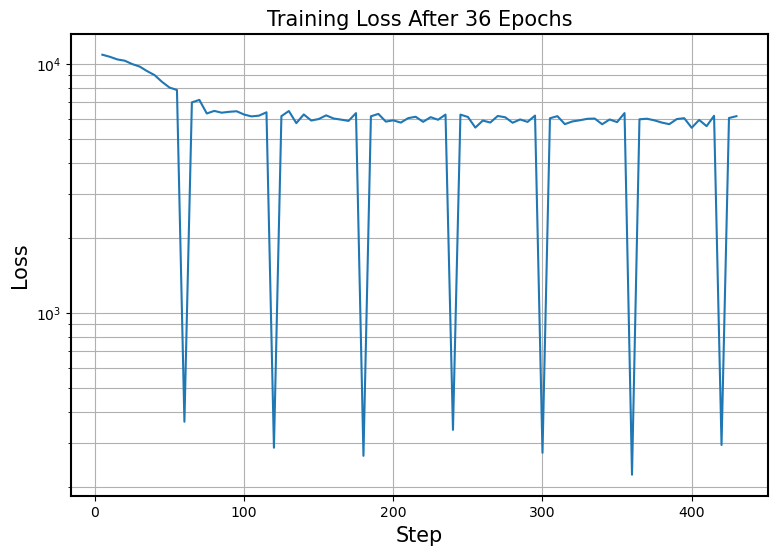

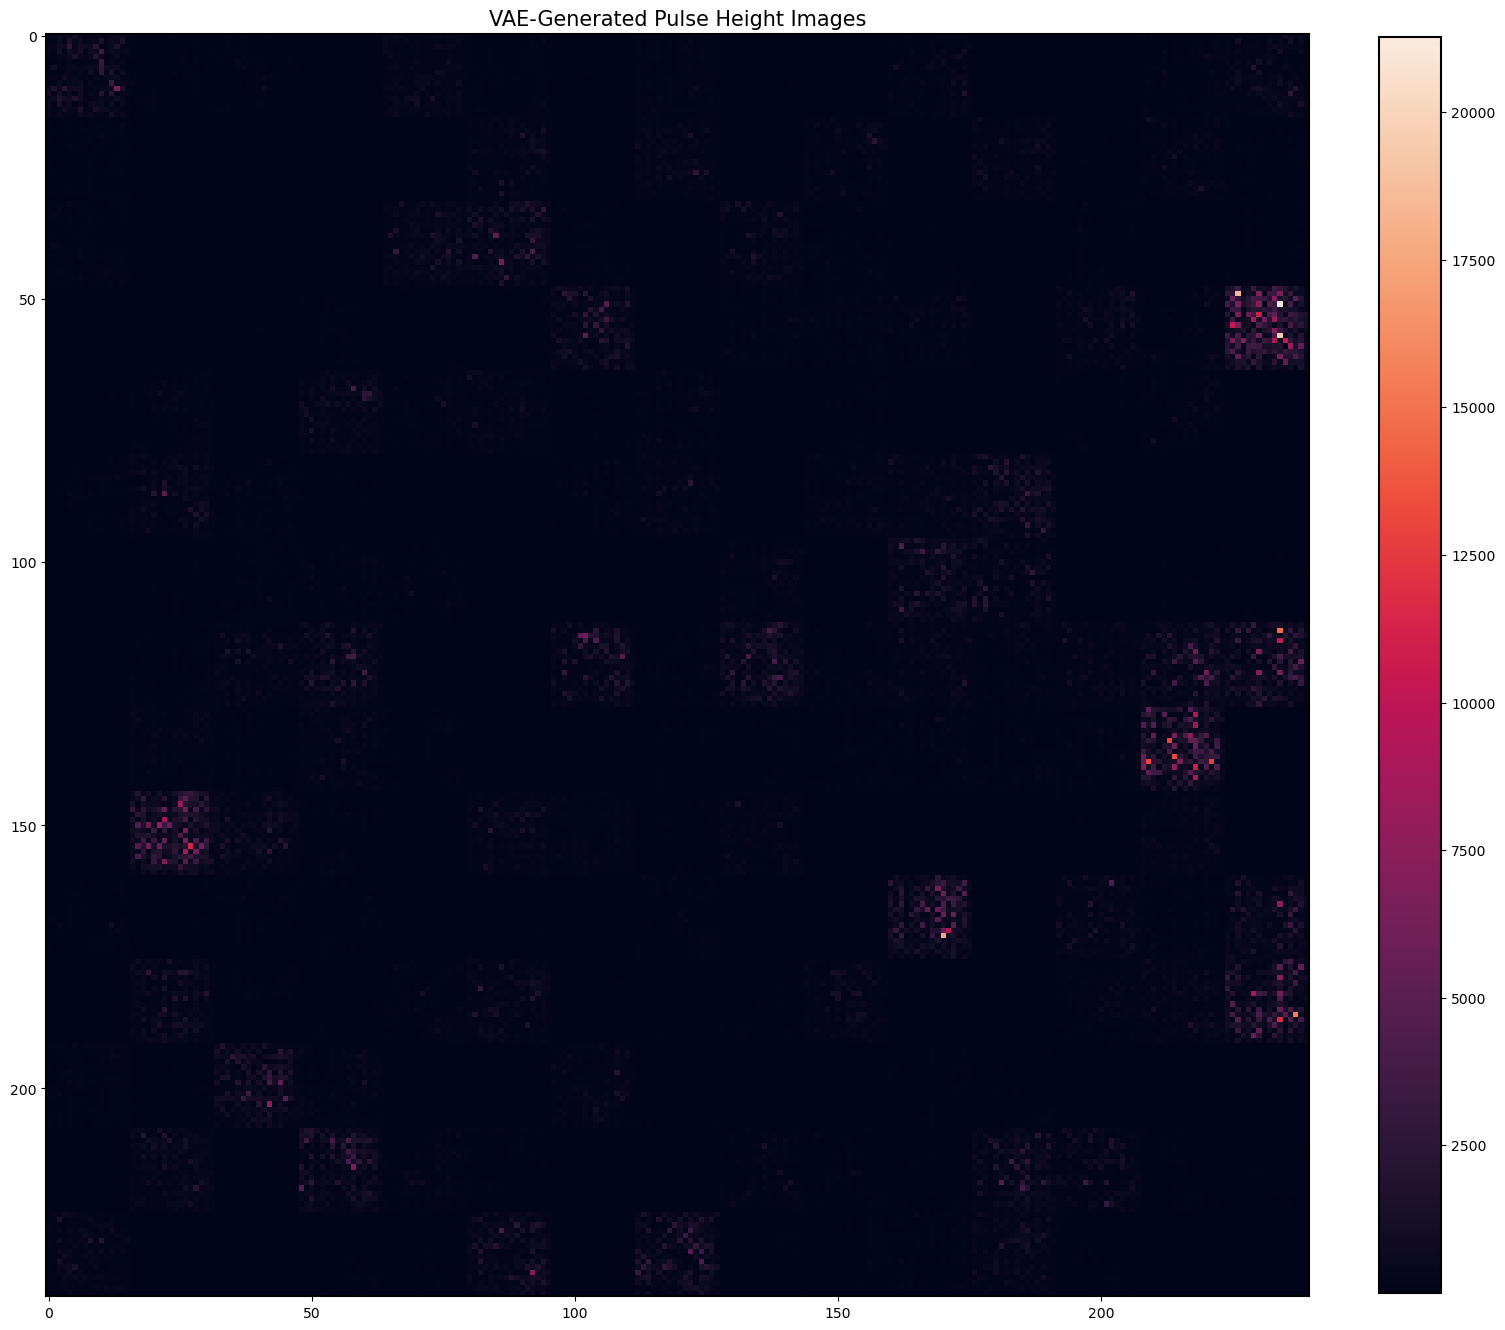

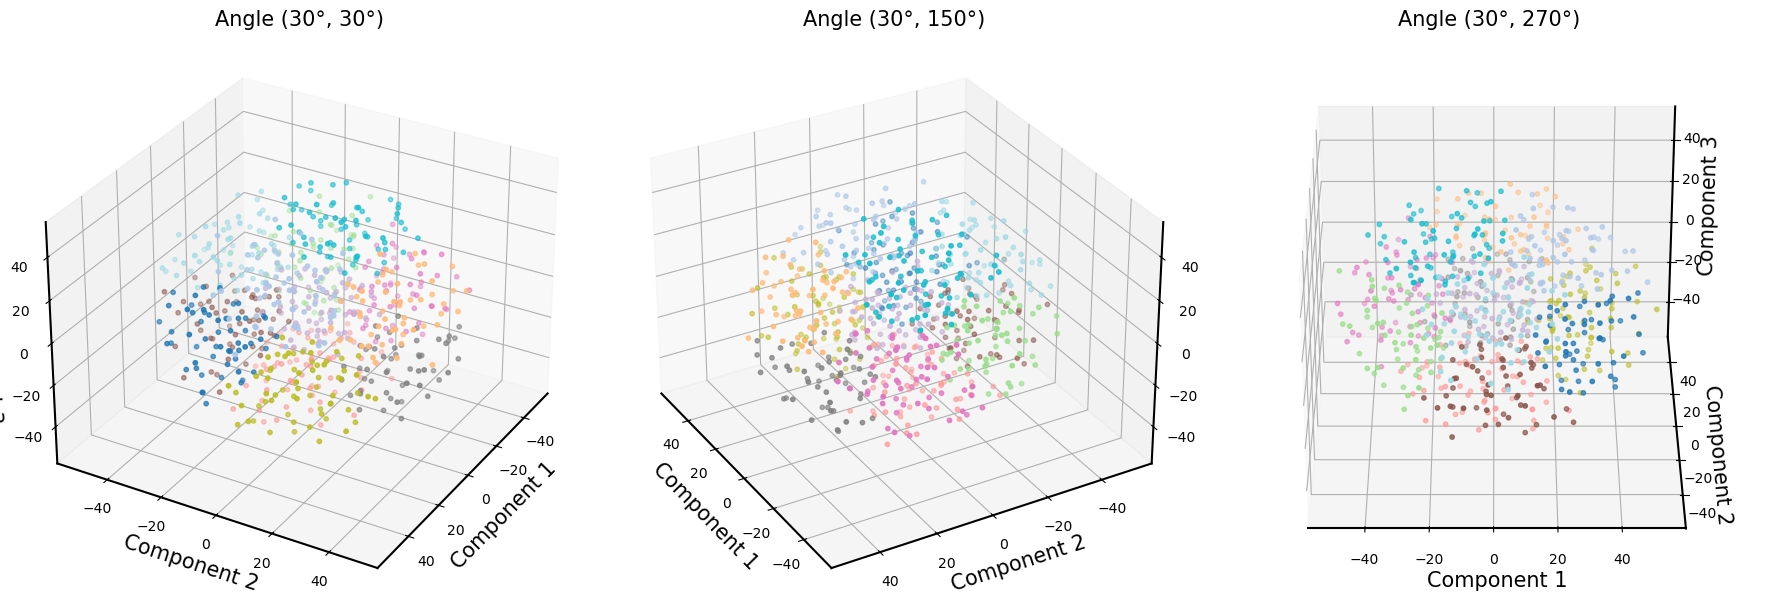

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 53.29batch/s]


Epoch 37



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 48.64batch/s]


Epoch 38



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 53.38batch/s]


Epoch 39



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 29.44batch/s]


Epoch 40



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 21.14batch/s]


Epoch 41

current lr =  [0.0001]


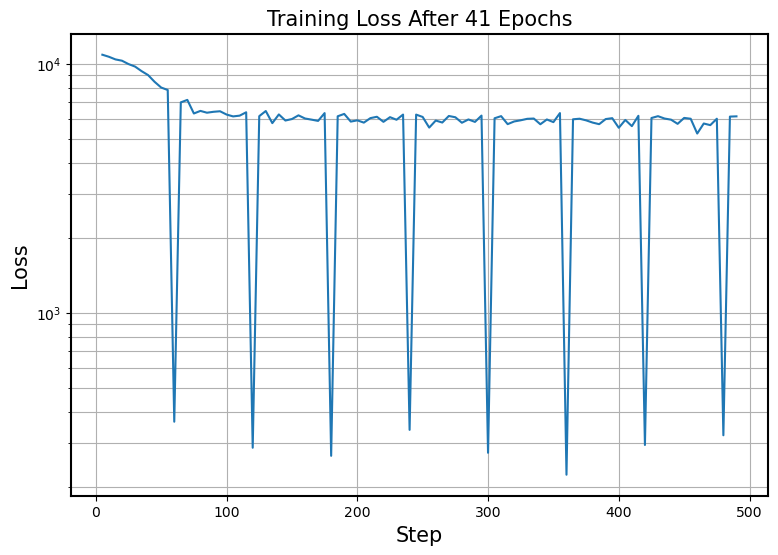

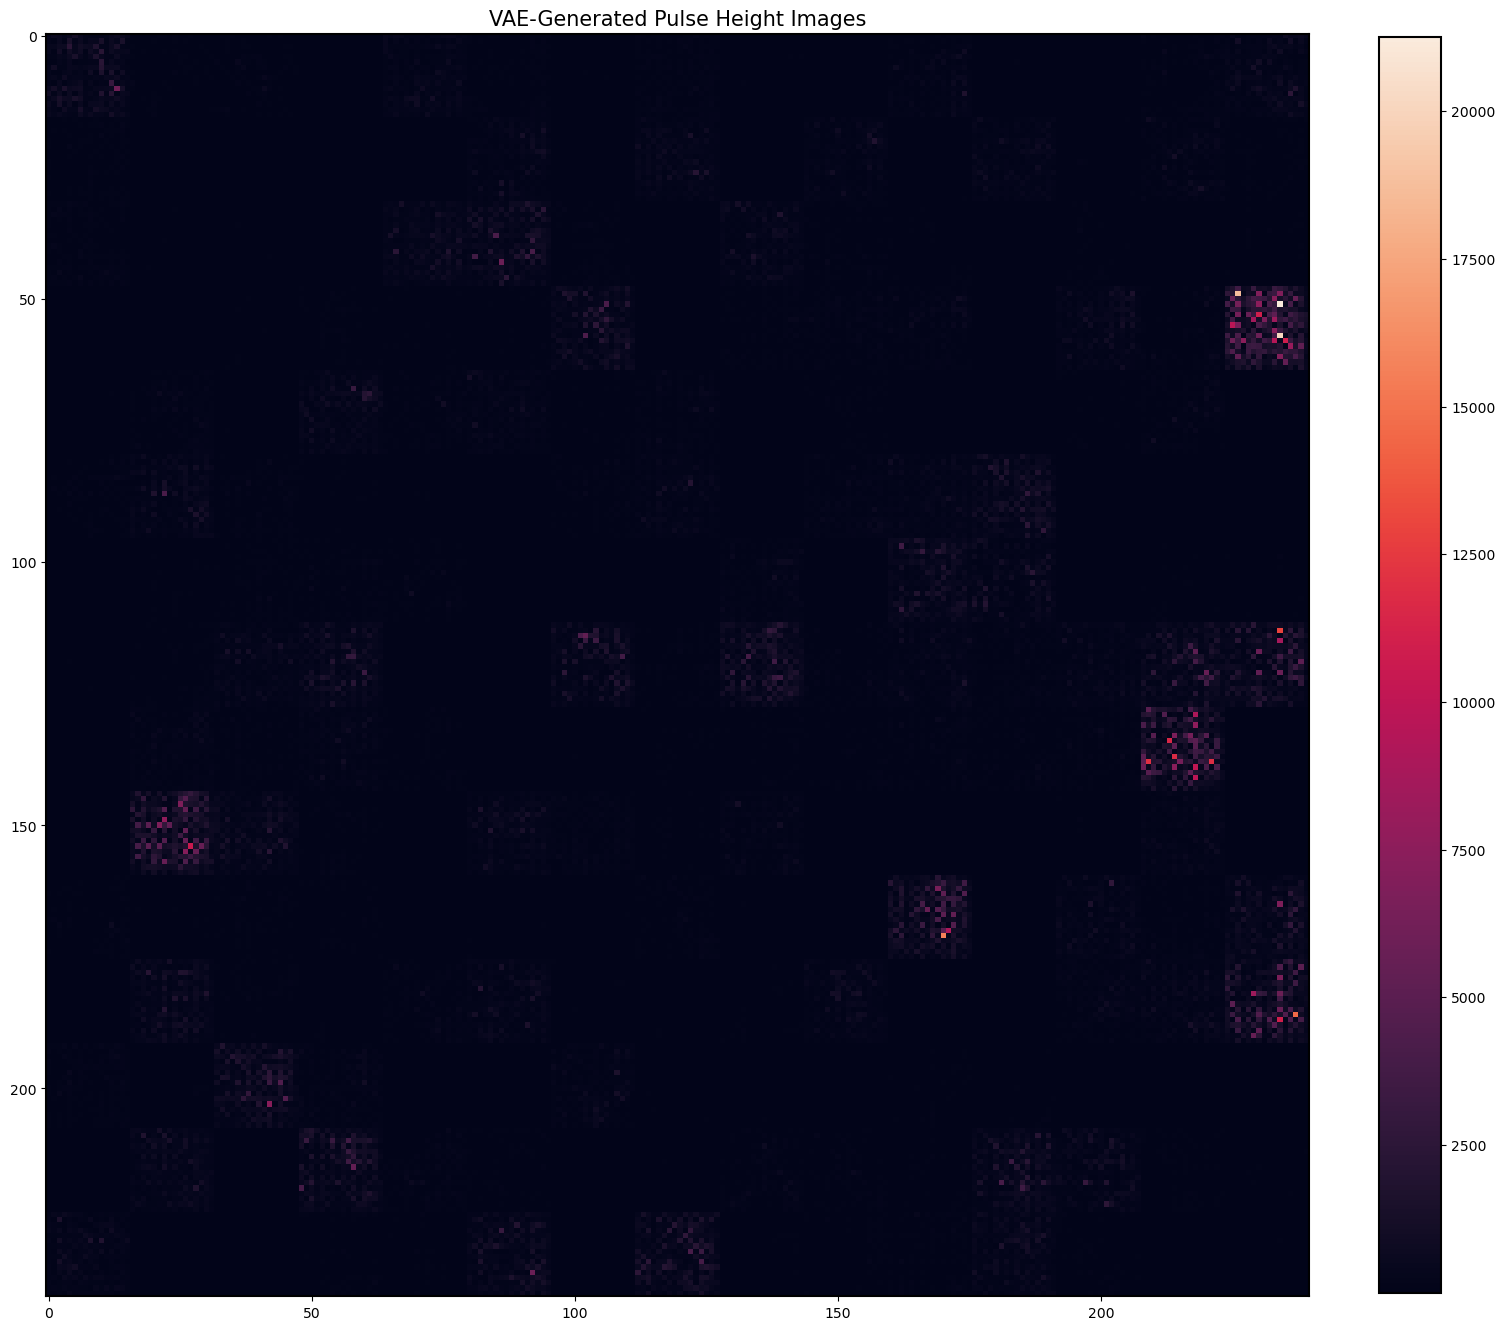

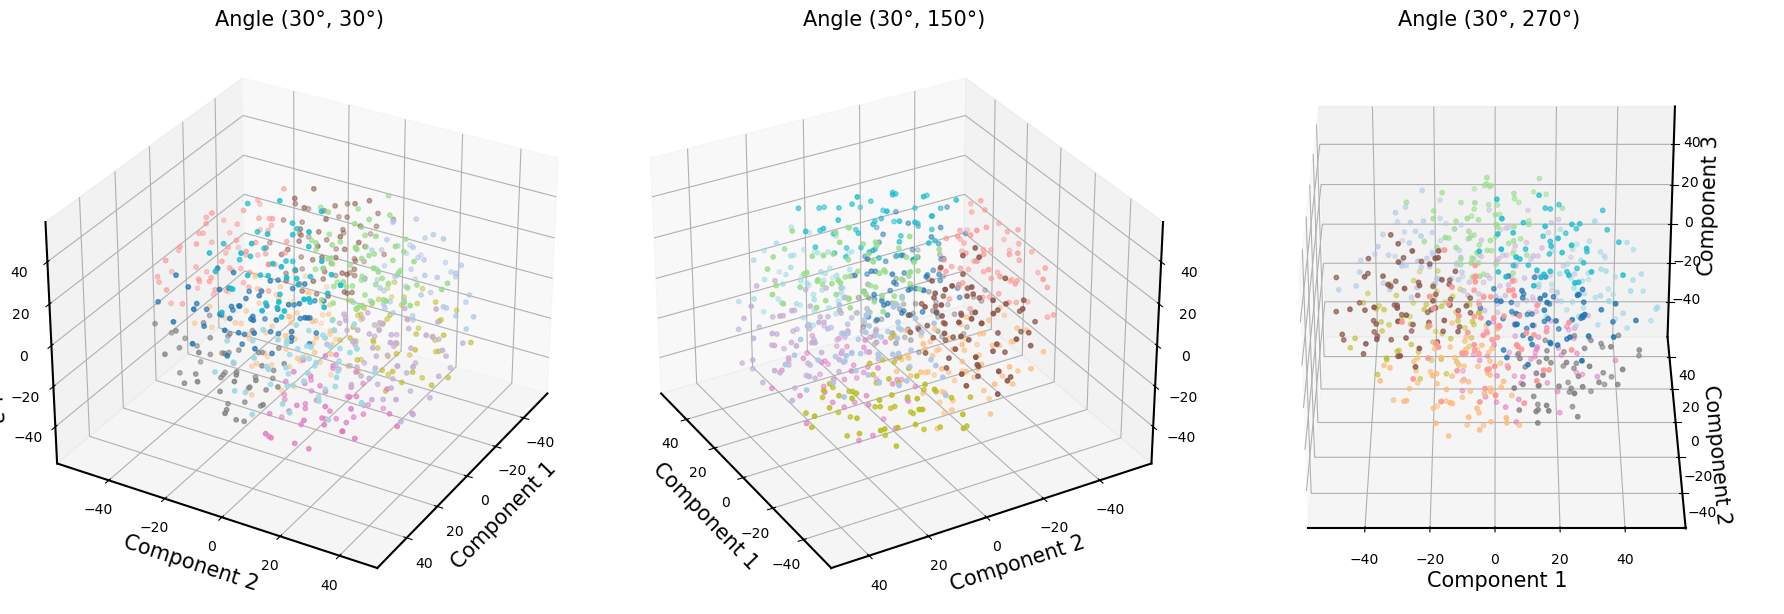

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 45.93batch/s]


Epoch 42



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 50.55batch/s]


Epoch 43



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 49.97batch/s]


Epoch 44



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 51.09batch/s]


Epoch 45



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 49.31batch/s]


Epoch 46

current lr =  [0.0001]


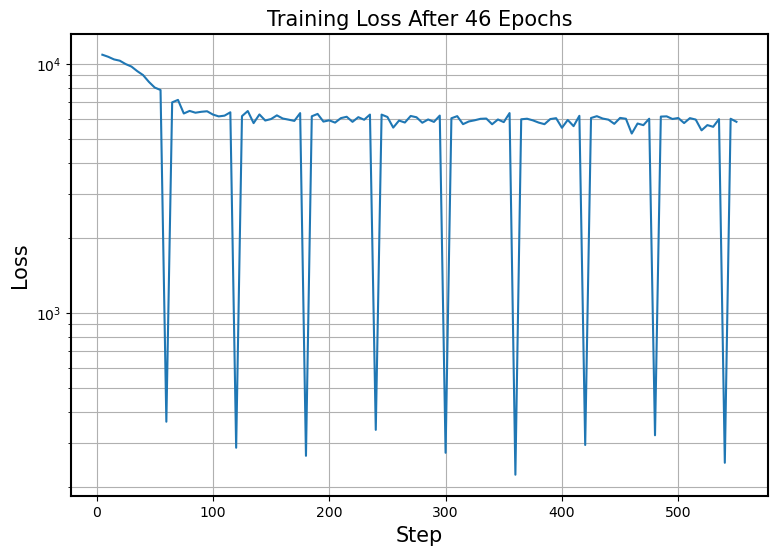

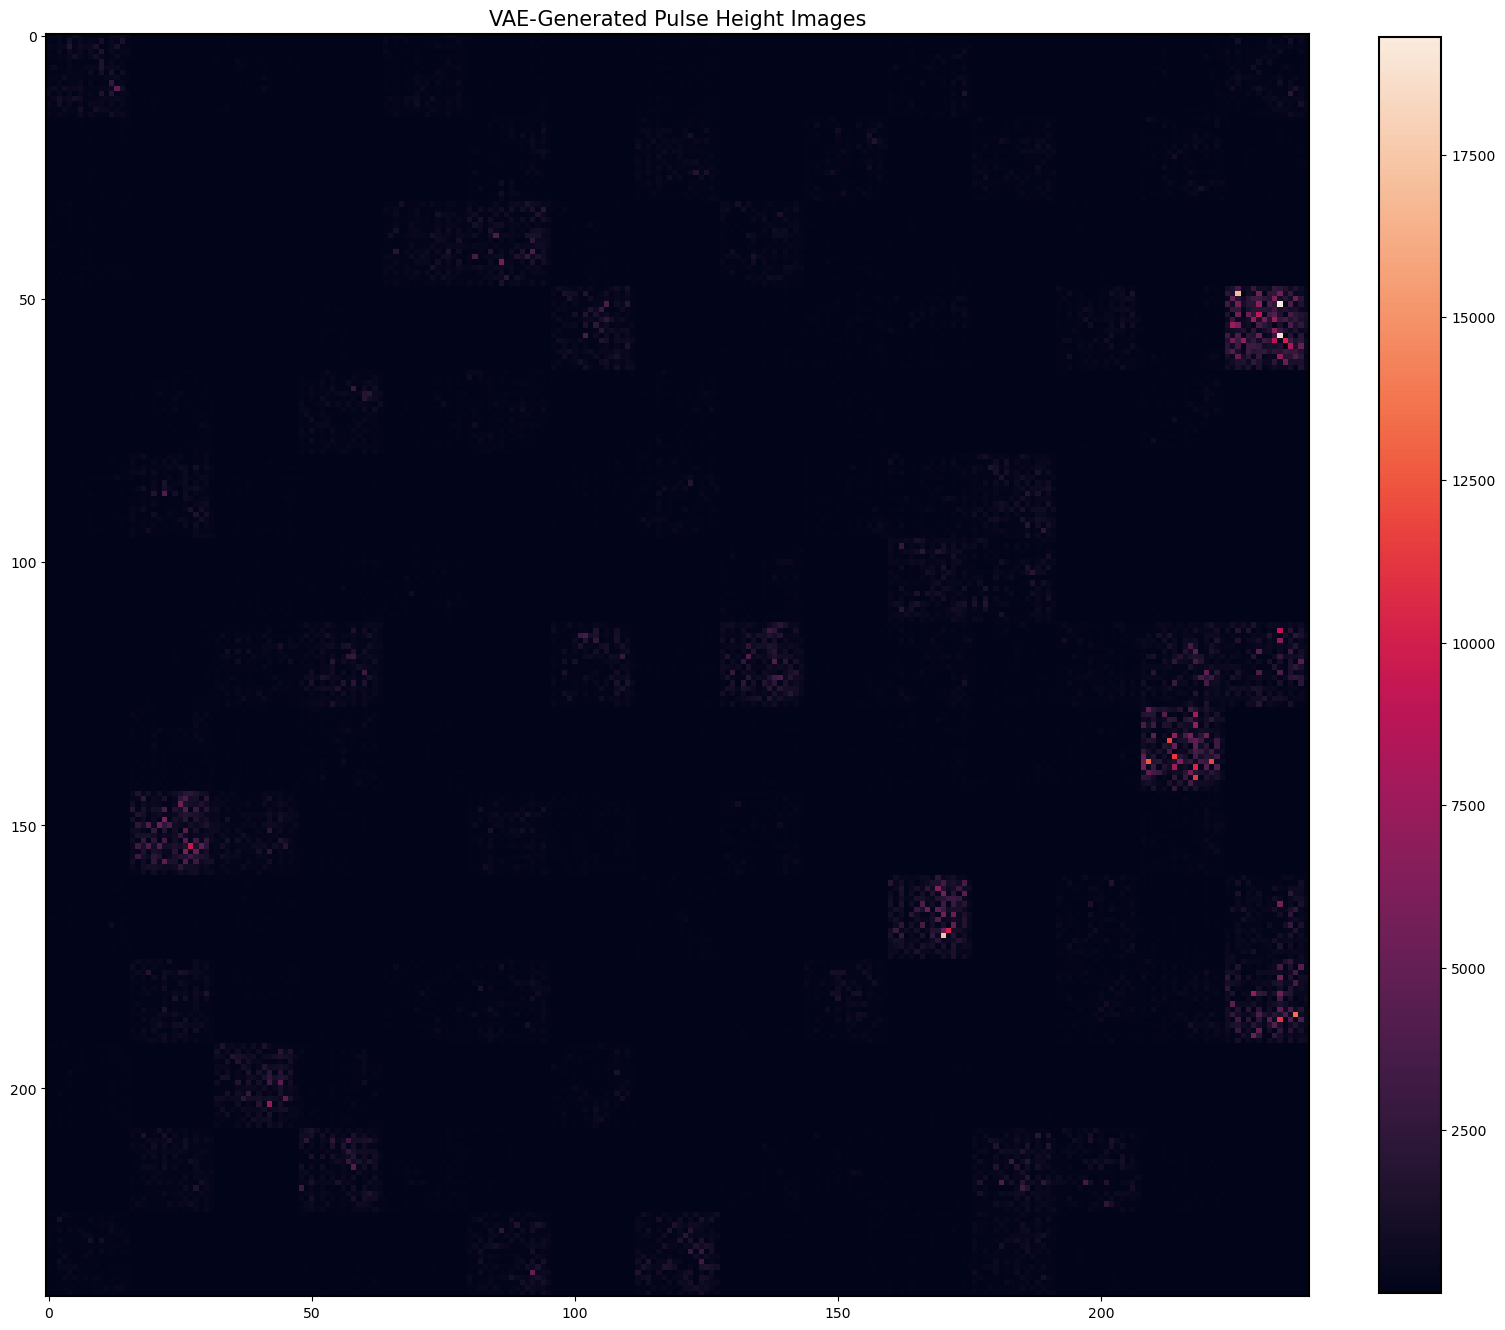

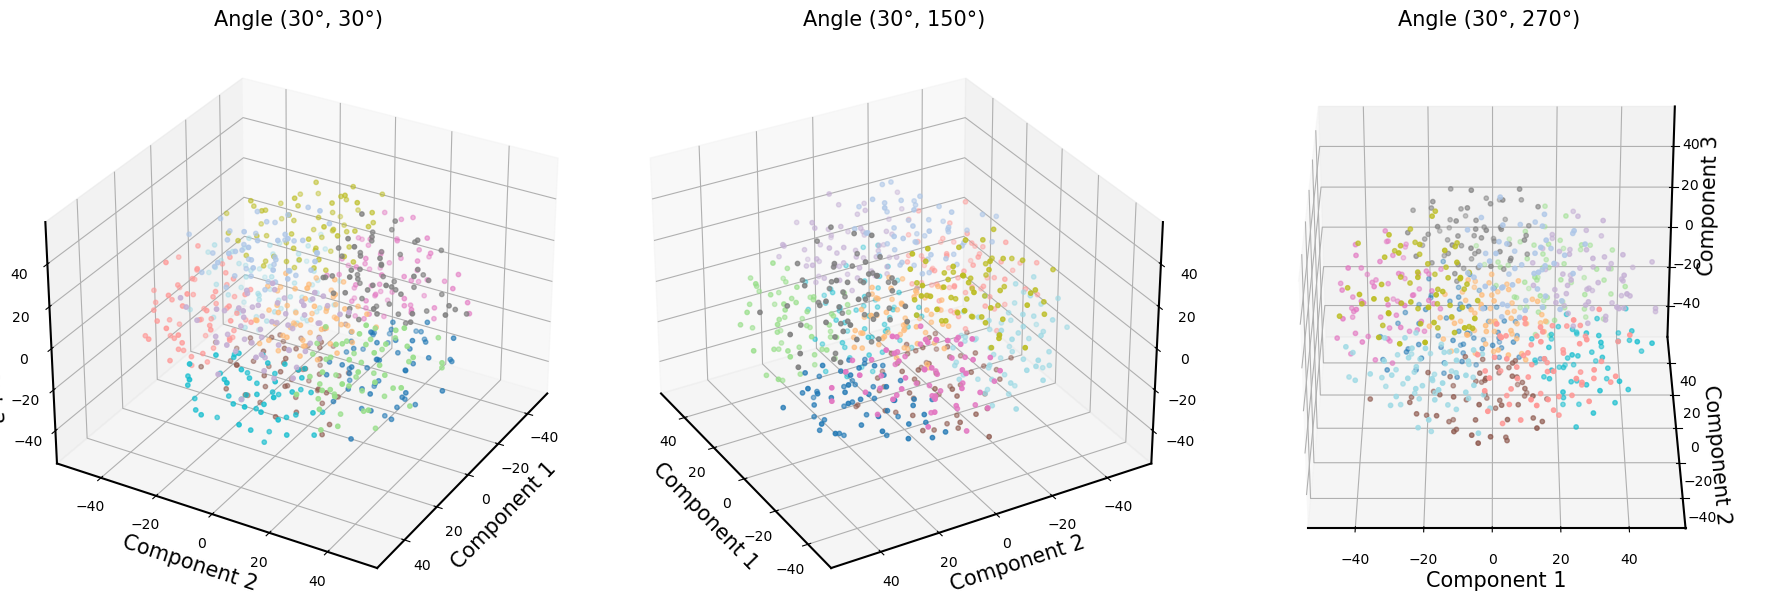

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 51.08batch/s]


Epoch 47



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 35.22batch/s]


Epoch 48



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 48.75batch/s]


Epoch 49



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 37.25batch/s]


Epoch 50



100%|████████████████████████████████████████| 12/12 [00:00<00:00, 35.70batch/s]


Epoch 51

current lr =  [0.0001]


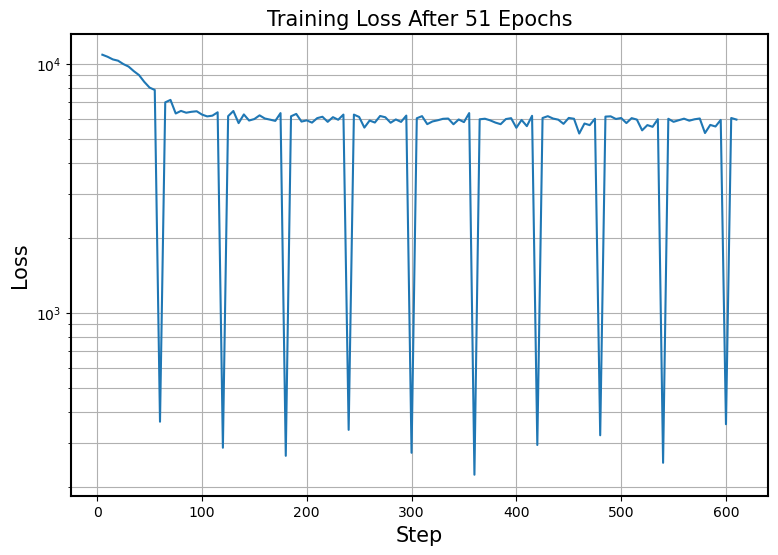

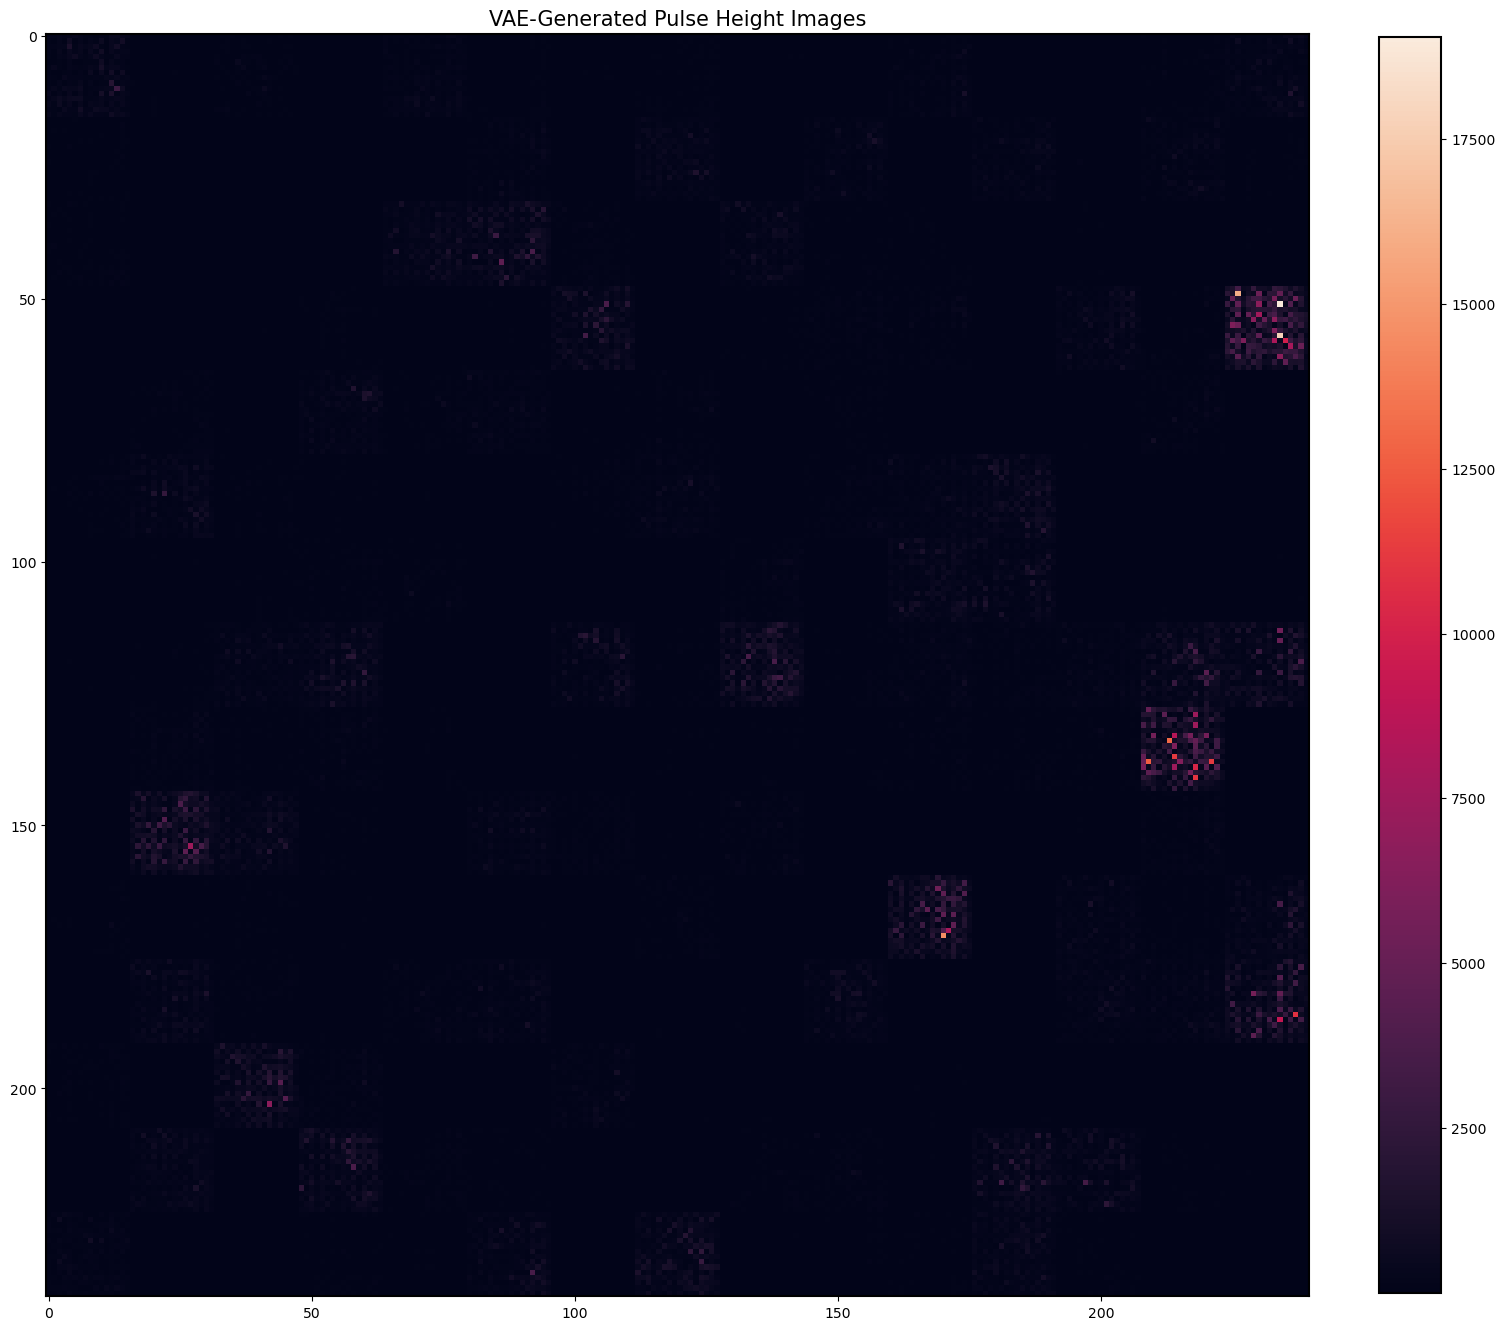

KeyboardInterrupt: 

In [14]:
train_config = {
    'model': BetaVAE,
    'hidden_dim': 84,
    'latent_dim': 48,
    'beta': 1.0,
    'sparsity_weight': 1e-2,
    'num_epochs': 71,
    'batch_size': 64,
    'gamma': 1.0,
    'lr': 1e-4,
    'weight_decay': 0,
    'n_clusters': 12,
}

model, log_df = train_vae(
    train_config,
    ph_dataset, 
    img_cwh = (1, 16, 16),
    seed = 15,
    verbose = True
)